# SDA Project

### Salvatore Marragony - 10617299

In [104]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pylab as plt
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay,  ConfusionMatrixDisplay

* Unified data for x and y. Check dimensions on y to be sure that they match with the ones described in the paper. Label 1 is for anomalous noise, 2 for normal noise

In [105]:
ids=['02','04','06']
x=np.load('valves/id_00/X.npy')
y=np.load('valves/id_00/y.npy')
print(np.unique(y[:,0], return_counts=True))
for i in ids:
    x_temp=np.load('valves/id_'+i+'/X.npy')
    y_temp=np.load('valves/id_'+i+'/y.npy')
    print(np.unique(y_temp[:,0], return_counts=True))
    x=np.concatenate((x,x_temp))
    y=np.concatenate((y,y_temp))
print(x.shape,y.shape)
    

(array([1, 2]), array([1071, 8919], dtype=int64))
(array([1, 2]), array([1080, 6372], dtype=int64))
(array([1, 2]), array([1080, 9000], dtype=int64))
(array([1, 2]), array([1080, 8928], dtype=int64))
(37530, 12935) (37530, 4)


# Pipeline

### Keep only first column and change label

In [106]:
def change_col_lab(y):
    y = y[:,0]
    y[y==2]=0
    return y

### Undersampling

In [107]:
def undersampling(x, y):
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(x, y)
    print("After undersampling:")
    print(np.unique(y_resampled, return_counts=True))
    return X_resampled, y_resampled


### Train-test split and one-hot encoding

In [108]:
def split_encoding(x, y, undersam=True):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    if undersam:
        X_train, y_train = undersampling(X_train, y_train)
    print('X_train shape: {}'.format(X_train.shape), 'y_train shape: {}'.format(y_train.shape), 'X_test shape: {}'.format(X_test.shape), 'y_test shape: {}'.format(y_test.shape))
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, X_test, y_train, y_test

### Model

In [109]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, TimeDistributed, Permute, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
EPOCHS = 200
LEARNING_RATE = 0.005
BATCH_SIZE = 32
es = EarlyStopping(patience=10,monitor='val_loss', mode='auto', verbose=False, min_delta=0)
pl=ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.1,verbose=False,min_lr=1e-11)
callbacks_list = [es,pl]

def getModel(seed):
    tf.random.set_seed(seed)
    classes=2
    input_length=12935
    # model architecture
    model = Sequential()
    model.add(Reshape((int(input_length / 65), 65), input_shape=(input_length,)))
    model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(20, activation='relu',
        activity_regularizer=tf.keras.regularizers.l1(0.00001)))
    model.add(Dense(10, activation='relu',
        activity_regularizer=tf.keras.regularizers.l1(0.00001)))
    model.add(Dense(classes, name='y_pred', activation='softmax'))

    # this controls the learning rate
    opt = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)


    # train the neural network
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


## Complete pipeline that returns the evaluation metrics

* 5 random seeds are chosen in order to show the high variance in the results from the models

In [235]:
random_seeds= np.random.randint(0, 100, size=5)


In [236]:
def pipeline(x,y, undersamp=True, name=None):
    #preprocessing
    print("====PREPROCESSING====")
    y = change_col_lab(y)
    print("Original dimension:")
    print(np.unique(y, return_counts=True))
    X_train, X_test, y_train, y_test = split_encoding(x,y, undersamp)
    print('test unique:')
    print(np.unique(y_test[:,1], return_counts=True))
    
    # model for each random seed
    models=[]
    accs=[]
    for seed in random_seeds:
        print("")
        print('seed: %d' %seed)
        model = getModel(seed)
        #model fitting
        print("====MODEL FITTING====")
        history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test), verbose=False, callbacks=callbacks_list).history
        models.append(model)
        #evaluation
        print("")
        print("====EVALUATION====")
        y_prob = model.predict(X_test)
        y_pred = np.argmax(y_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
        f1 = f1_score(y_true, y_pred)
        test_loss, test_acc = model.evaluate(X_test, y_test)
        print('Test accuracy:', test_acc)
        print('f1-score:', f1)
        accs.append(test_acc)
    
    plt.boxplot(accs)
    plt.ylabel('Accuracy')
    plt.title('Variation of Accuracy with Different Random Seeds')
    plt.show()
    
    #filter out from accs the value(s) that are outliers
    accs = np.array(accs)
    mean = np.mean(accs)
    std = np.std(accs)
    z_scores = np.abs((accs - mean) / std)
    print(z_scores)
    outlier_indices = np.where(z_scores > 1.5)[0]
    print("Accuracy outlier:")
    print(accs[outlier_indices])
    accs = [v for i, v in enumerate(accs) if i not in outlier_indices]
    models = [s for i, s in enumerate(models) if i not in outlier_indices]
    best_model = models[np.argmax(accs)]
    
    if name is not None:
        best_model.save(".//" +name)
    # evaluation on the test set
    print("Accuracy mean and std: %.2f%% (+/- %.2f%%)" % (np.mean(accs), np.std(accs)))
    print("BEST MODEL:")
    y_prob = best_model.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1 = f1_score(y_true, y_pred)
    test_loss, test_acc = best_model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)
    print('f1-score:', f1)
    # Create a confusion matrix
    labels = ['Normal', 'Anomalies']
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    report = classification_report(y_true, y_pred)
    print('Confusion matrix:')
    print(df_cm)
    print(report)
    return f1, np.mean(accs), df_cm, report

# Different models

## Without undersampling

====PREPROCESSING====
Original dimension:
(array([0, 1]), array([33219,  4311], dtype=int64))
X_train shape: (30024, 12935) y_train shape: (30024,) X_test shape: (7506, 12935) y_test shape: (7506,)
test unique:
(array([0., 1.], dtype=float32), array([6691,  815], dtype=int64))

seed: 38
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 4ms/step - loss: 0.0685 - accuracy: 0.9780
Test accuracy: 0.9780175685882568
f1-score: 0.8888888888888888

seed: 78
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 4ms/step - loss: 0.1837 - accuracy: 0.8914
Test accuracy: 0.8914201855659485
f1-score: 0.0

seed: 10
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 4ms/step - loss: 0.0700 - accuracy: 0.9774
Test accuracy: 0.9773514270782471
f1-score: 0.8851351351351351

seed: 22
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 3ms/step - loss: 0.0697 - a

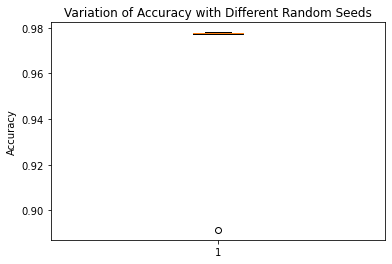

[0.51061023 1.99995599 0.49129796 0.50288601 0.49516179]
Accuracy outlier:
[0.89142019]
Accuracy mean and std: 0.98% (+/- 0.00%)
BEST MODEL:
235/235 [==============================] - 1s 3ms/step - loss: 0.0685 - accuracy: 0.9780
Test accuracy: 0.9780175685882568
f1-score: 0.8888888888888888
Confusion matrix:
           Normal  Anomalies
Normal       6681         10
Anomalies     155        660
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6691
           1       0.99      0.81      0.89       815

    accuracy                           0.98      7506
   macro avg       0.98      0.90      0.94      7506
weighted avg       0.98      0.98      0.98      7506



In [237]:
f1_no, test_acc_no, df_cm_no, report_no = pipeline(x,y, undersamp=False)

## Undersampling


====PREPROCESSING====
Original dimension:
(array([0, 1]), array([33219,  4311], dtype=int64))


After undersampling:
(array([0, 1]), array([3496, 3496], dtype=int64))
X_train shape: (6992, 12935) y_train shape: (6992,) X_test shape: (7506, 12935) y_test shape: (7506,)
test unique:
(array([0., 1.], dtype=float32), array([6691,  815], dtype=int64))

seed: 38
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 3ms/step - loss: 0.3276 - accuracy: 0.8324
Test accuracy: 0.8324007391929626
f1-score: 0.5641025641025641

seed: 78
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.1086
Test accuracy: 0.10857979953289032
f1-score: 0.19588991707727438

seed: 10
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 4ms/step - loss: 0.1336 - accuracy: 0.8480
Test accuracy: 0.8479882478713989
f1-score: 0.5873417721518986

seed: 22
====MODEL FITTING====

====EVALUATION====
235/235 [==============================] - 1s 4ms/step - loss: 0.1507 - accuracy:

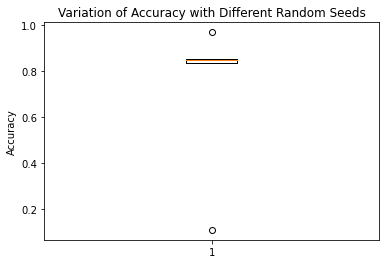

[0.35593583 1.97562845 0.40614615 0.42116652 0.79237995]
Accuracy outlier:
[0.1085798]


INFO:tensorflow:Assets written to: .//ModelUnified\assets


INFO:tensorflow:Assets written to: .//ModelUnified\assets


Accuracy mean and std: 0.88% (+/- 0.05%)
BEST MODEL:
235/235 [==============================] - 1s 4ms/step - loss: 0.1430 - accuracy: 0.9679
Test accuracy: 0.9678923487663269
f1-score: 0.8477574226152874
Confusion matrix:
           Normal  Anomalies
Normal       6594         97
Anomalies     144        671
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6691
           1       0.87      0.82      0.85       815

    accuracy                           0.97      7506
   macro avg       0.93      0.90      0.91      7506
weighted avg       0.97      0.97      0.97      7506



In [238]:
f1, test_acc, df_cm, report = pipeline(x,y, name="ModelUnified")

# valve 00

In [239]:
x_00=np.load('valves/id_00/X.npy')
y_00=np.load('valves/id_00/y.npy')
x_00.shape, y_00.shape

((9990, 12935), (9990, 4))

In [240]:
print(np.unique(y_00[:,0], return_counts=True))

(array([1, 2]), array([1071, 8919], dtype=int64))


====PREPROCESSING====
Original dimension:
(array([0, 1]), array([8919, 1071], dtype=int64))
After undersampling:
(array([0, 1]), array([861, 861], dtype=int64))
X_train shape: (1722, 12935) y_train shape: (1722,) X_test shape: (1998, 12935) y_test shape: (1998,)
test unique:
(array([0., 1.], dtype=float32), array([1788,  210], dtype=int64))

seed: 38
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 4ms/step - loss: 0.1318 - accuracy: 0.9725
Test accuracy: 0.9724724888801575
f1-score: 0.856396866840731

seed: 78
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 4ms/step - loss: 0.1377 - accuracy: 0.9750
Test accuracy: 0.9749749898910522
f1-score: 0.8677248677248677

seed: 10
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9770
Test accuracy: 0.9769769906997681
f1-score: 0.877005347593583

seed: 22
====MODEL FITTING====

====EVALUATION====
6

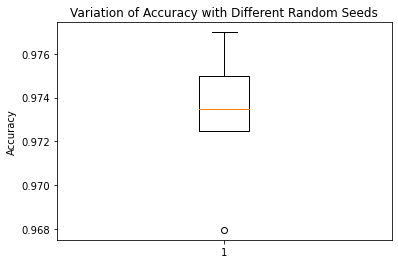

[0.23255942 0.59800994 1.26246544 0.09966832 1.72758428]
Accuracy outlier:
[0.96796799]


INFO:tensorflow:Assets written to: .//Model00\assets


INFO:tensorflow:Assets written to: .//Model00\assets


Accuracy mean and std: 0.97% (+/- 0.00%)
BEST MODEL:
63/63 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9770
Test accuracy: 0.9769769906997681
f1-score: 0.877005347593583
Confusion matrix:
           Normal  Anomalies
Normal       1788          0
Anomalies      46        164
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1788
           1       1.00      0.78      0.88       210

    accuracy                           0.98      1998
   macro avg       0.99      0.89      0.93      1998
weighted avg       0.98      0.98      0.98      1998



In [241]:
f1_00, test_acc_00, df_cm_00, report_00 = pipeline(x_00, y_00, name="Model00")

In [242]:
print("Report unified model:")
print(report)
print("")
print("Report model only with valve 00:")
print(report_00)
print("Accuracy unified model: %f" %test_acc)
print("Accuracy model only with valve 00: %f" %test_acc_00)

Report unified model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6691
           1       0.87      0.82      0.85       815

    accuracy                           0.97      7506
   macro avg       0.93      0.90      0.91      7506
weighted avg       0.97      0.97      0.97      7506


Report model only with valve 00:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1788
           1       1.00      0.78      0.88       210

    accuracy                           0.98      1998
   macro avg       0.99      0.89      0.93      1998
weighted avg       0.98      0.98      0.98      1998

Accuracy unified model: 0.875233
Accuracy model only with valve 00: 0.974474


## Valve 02

In [243]:
x_02=np.load('valves/id_02/X.npy')
y_02=np.load('valves/id_02/y.npy')
x_02.shape, y_02.shape

((7452, 12935), (7452, 4))

====PREPROCESSING====
Original dimension:
(array([0, 1]), array([6372, 1080], dtype=int64))
After undersampling:
(array([0, 1]), array([869, 869], dtype=int64))
X_train shape: (1738, 12935) y_train shape: (1738,) X_test shape: (1491, 12935) y_test shape: (1491,)
test unique:
(array([0., 1.], dtype=float32), array([1280,  211], dtype=int64))

seed: 38
====MODEL FITTING====

====EVALUATION====
47/47 [==============================] - 0s 4ms/step - loss: 0.4116 - accuracy: 0.7619
Test accuracy: 0.761904776096344
f1-score: 0.5431145431145431

seed: 78
====MODEL FITTING====

====EVALUATION====
47/47 [==============================] - 0s 4ms/step - loss: 0.1614 - accuracy: 0.9691
Test accuracy: 0.9691482186317444
f1-score: 0.8832487309644669

seed: 10
====MODEL FITTING====

====EVALUATION====
47/47 [==============================] - 0s 4ms/step - loss: 0.1555 - accuracy: 0.9705
Test accuracy: 0.9704896211624146
f1-score: 0.8835978835978835

seed: 22
====MODEL FITTING====

====EVALUATION====


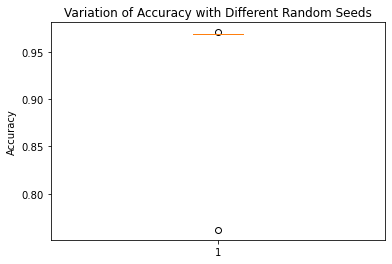

[1.99996085 0.49595146 0.51210648 0.49595146 0.49595146]
Accuracy outlier:
[0.76190478]


INFO:tensorflow:Assets written to: .//Model02\assets


INFO:tensorflow:Assets written to: .//Model02\assets


Accuracy mean and std: 0.97% (+/- 0.00%)
BEST MODEL:
47/47 [==============================] - 0s 4ms/step - loss: 0.1555 - accuracy: 0.9705
Test accuracy: 0.9704896211624146
f1-score: 0.8835978835978835
Confusion matrix:
           Normal  Anomalies
Normal       1280          0
Anomalies      44        167
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1280
           1       1.00      0.79      0.88       211

    accuracy                           0.97      1491
   macro avg       0.98      0.90      0.93      1491
weighted avg       0.97      0.97      0.97      1491



In [244]:
f1_02, test_acc_02, df_cm_02, report_02 = pipeline(x_02, y_02, name="Model02")

In [245]:
print("Report unified model:")
print(report)
print("")
print("Report model only with valve 02:")
print(report_02)
print("Accuracy unified model: %f" %test_acc)
print("Accuracy model only with valve 02: %f" %test_acc_02)

Report unified model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6691
           1       0.87      0.82      0.85       815

    accuracy                           0.97      7506
   macro avg       0.93      0.90      0.91      7506
weighted avg       0.97      0.97      0.97      7506


Report model only with valve 02:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1280
           1       1.00      0.79      0.88       211

    accuracy                           0.97      1491
   macro avg       0.98      0.90      0.93      1491
weighted avg       0.97      0.97      0.97      1491

Accuracy unified model: 0.875233
Accuracy model only with valve 02: 0.969484


## Valve 04

In [246]:
x_04=np.load('valves/id_04/X.npy')
y_04=np.load('valves/id_04/y.npy')
x_04.shape, y_04.shape

((10080, 12935), (10080, 4))

====PREPROCESSING====
Original dimension:
(array([0, 1]), array([9000, 1080], dtype=int64))
After undersampling:
(array([0, 1]), array([859, 859], dtype=int64))
X_train shape: (1718, 12935) y_train shape: (1718,) X_test shape: (2016, 12935) y_test shape: (2016,)
test unique:
(array([0., 1.], dtype=float32), array([1795,  221], dtype=int64))

seed: 38
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 3ms/step - loss: 0.1287 - accuracy: 0.9405
Test accuracy: 0.9404761791229248
f1-score: 0.7744360902255639

seed: 78
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 3ms/step - loss: 0.1253 - accuracy: 0.9271
Test accuracy: 0.9270833134651184
f1-score: 0.7272727272727273

seed: 10
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 3ms/step - loss: 0.1066 - accuracy: 0.9578
Test accuracy: 0.9578372836112976
f1-score: 0.8210526315789473

seed: 22
====MODEL FITTING====

====EVALUATION====

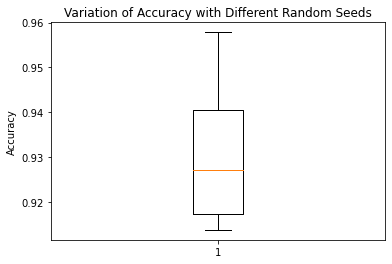

[0.56866126 0.25681523 1.63872228 1.08229172 0.86827658]
Accuracy outlier:
[0.95783728]


INFO:tensorflow:Assets written to: .//Model04\assets


INFO:tensorflow:Assets written to: .//Model04\assets


Accuracy mean and std: 0.92% (+/- 0.01%)
BEST MODEL:
63/63 [==============================] - 0s 4ms/step - loss: 0.1287 - accuracy: 0.9405
Test accuracy: 0.9404761791229248
f1-score: 0.7744360902255639
Confusion matrix:
           Normal  Anomalies
Normal       1690        105
Anomalies      15        206
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1795
           1       0.66      0.93      0.77       221

    accuracy                           0.94      2016
   macro avg       0.83      0.94      0.87      2016
weighted avg       0.96      0.94      0.94      2016



In [247]:
f1_04, test_acc_04, df_cm_04, report_04 = pipeline(x_04, y_04, name="Model04")

In [248]:
print("Report unified model:")
print(report)
print("")
print("Report model only with valve 04:")
print(report_04)
print("Accuracy unified model: %f" %test_acc)
print("Accuracy model only with valve 04: %f" %test_acc_04)

Report unified model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6691
           1       0.87      0.82      0.85       815

    accuracy                           0.97      7506
   macro avg       0.93      0.90      0.91      7506
weighted avg       0.97      0.97      0.97      7506


Report model only with valve 04:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1795
           1       0.66      0.93      0.77       221

    accuracy                           0.94      2016
   macro avg       0.83      0.94      0.87      2016
weighted avg       0.96      0.94      0.94      2016

Accuracy unified model: 0.875233
Accuracy model only with valve 04: 0.924603


## Valve 06

In [249]:
x_06=np.load('valves/id_06/X.npy')
y_06=np.load('valves/id_06/y.npy')
x_06.shape, y_06.shape

((10008, 12935), (10008, 4))

====PREPROCESSING====
Original dimension:
(array([0, 1]), array([8928, 1080], dtype=int64))
After undersampling:
(array([0, 1]), array([867, 867], dtype=int64))
X_train shape: (1734, 12935) y_train shape: (1734,) X_test shape: (2002, 12935) y_test shape: (2002,)
test unique:
(array([0., 1.], dtype=float32), array([1789,  213], dtype=int64))

seed: 38
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 4ms/step - loss: 0.1436 - accuracy: 0.9555
Test accuracy: 0.9555444717407227
f1-score: 0.8126315789473684

seed: 78
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 3ms/step - loss: 0.1739 - accuracy: 0.8472
Test accuracy: 0.847152829170227
f1-score: 0.5808219178082192

seed: 10
====MODEL FITTING====

====EVALUATION====
63/63 [==============================] - 0s 3ms/step - loss: 0.2192 - accuracy: 0.9760
Test accuracy: 0.9760239720344543
f1-score: 0.8805970149253731

seed: 22
====MODEL FITTING====

====EVALUATION====


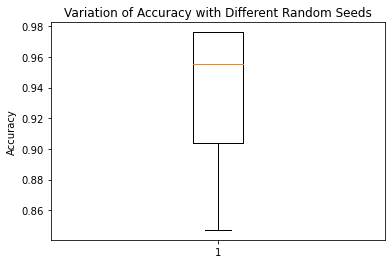

[0.47728502 1.6985719  0.88839109 0.55549531 0.88839109]
Accuracy outlier:
[0.84715283]


INFO:tensorflow:Assets written to: .//Model06\assets


INFO:tensorflow:Assets written to: .//Model06\assets


Accuracy mean and std: 0.95% (+/- 0.03%)
BEST MODEL:
63/63 [==============================] - 0s 3ms/step - loss: 0.2192 - accuracy: 0.9760
Test accuracy: 0.9760239720344543
f1-score: 0.8805970149253731
Confusion matrix:
           Normal  Anomalies
Normal       1777         12
Anomalies      36        177
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1789
           1       0.94      0.83      0.88       213

    accuracy                           0.98      2002
   macro avg       0.96      0.91      0.93      2002
weighted avg       0.98      0.98      0.98      2002



In [250]:
f1_06, test_acc_06, df_cm_06, report_06 = pipeline(x_06, y_06, name="Model06")

In [251]:
print("Report unified model:")
print(report)
print("")
print("Report model only with valve 06:")
print(report_06)
print("Accuracy unified model: %f" %test_acc)
print("Accuracy model only with valve 06: %f" %test_acc_06)

Report unified model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6691
           1       0.87      0.82      0.85       815

    accuracy                           0.97      7506
   macro avg       0.93      0.90      0.91      7506
weighted avg       0.97      0.97      0.97      7506


Report model only with valve 06:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1789
           1       0.94      0.83      0.88       213

    accuracy                           0.98      2002
   macro avg       0.96      0.91      0.93      2002
weighted avg       0.98      0.98      0.98      2002

Accuracy unified model: 0.875233
Accuracy model only with valve 06: 0.952922


## Comparison between different models

In [252]:
labels=['unified', '00', '02', '04', '06']
f1_list=[f1, f1_00, f1_02, f1_04, f1_06]
acc_list=[test_acc, test_acc_00, test_acc_02, test_acc_04, test_acc_06]

Text(0.5, 1.0, 'accuracy (mean)')

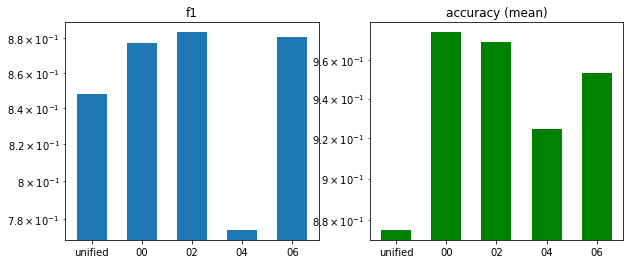

In [253]:
fig, ax= plt.subplots(1,2, figsize=(10,4))
ax[0].bar(labels, f1_list, width=0.6, log=True)
ax[0].set_title("f1")
ax[1].bar(labels, acc_list, width=0.6, log=True,color='green')
ax[1].set_title("accuracy (mean)")

# SML part

In [139]:
from river import anomaly
from river import preprocessing
from river import metrics
from river import datasets
from river import compose

### Data preprocessing through transfer learning

In [179]:
def transfer_learning(x, name, flatten=True):

    model = tf.keras.models.load_model(name)


    if flatten:  # output shape 800
        new_model = tf.keras.models.Sequential(model.layers[:-3])
        shape=800
    else:  # CUT == 'dense'  output shape 20
        new_model = tf.keras.models.Sequential(model.layers[:-2])
        shape=20


    original_features = x.copy()
    big_array = np.empty((x.shape[0], shape)) 
    for i in tqdm(range(original_features.shape[0])):
        # Example using only the first row
        row = original_features[i]
        #print("Dimensionality before NN Feature Extractor", len(row))

        ## use the following command to create the features from a single instance of data on which to train the SML Anomaly Detector
        features = new_model.predict(np.array(row)[None], verbose=0)
        big_array[i,:]=features
        #print("Dimensionality after NN Feature Extractor", len(features[0]))
    print('New shape:')
    print(big_array.shape)
    return big_array

### Train-test split with a 80-20% ratio keeping the distribution of the data

In [167]:
from sklearn.model_selection import train_test_split

def data_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
    # Sort the data by the label in ascending order (0 first, then 1)
    data_sorted = data[data[:, -1].argsort()]
    X_train = data_sorted[:, :-1]
    y_train = data_sorted[:, -1]
    data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
    # Sort the data by the label in ascending order (0 first, then 1)
    data_sorted = data[data[:, -1].argsort()]
    X_test = data_sorted[:, :-1]
    y_test = data_sorted[:, -1]
    
    # Verify the proportion of labels is maintained in both datasets
    print("Training set label proportions:", sum(y_train == 0)/len(y_train), sum(y_train == 1)/len(y_train))
    print("Testing set label proportions:", sum(y_test == 0)/len(y_test), sum(y_test == 1)/len(y_test))
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].plot(y)
    ax[0].set_title('Label distribution before split')
    ax[1].plot(y_train)
    ax[1].set_title('Label distribution in train')
    ax[2].plot(y_test)
    ax[2].set_title('Label distribution in test')
    plt.show()
    return X_train, X_test, y_train, y_test

### First we use the training data to find the right threshold value exploiting the roc curve

In [168]:
def compute_roc(x,y, WINDOW_SIZE):
    #Preprocessing
    if x.max()>1:
        model = compose.Pipeline(
            preprocessing.MinMaxScaler(),
            anomaly.HalfSpaceTrees(seed=42,n_trees=15, window_size=WINDOW_SIZE))
    else:
        model = anomaly.HalfSpaceTrees(seed=42,n_trees=15, window_size=WINDOW_SIZE)
    scores=[]
    for i in range(WINDOW_SIZE):
        ic = {'c'+str(j): x[i,j] for j in range(x.shape[1])}
        model = model.learn_one(ic)
    for i in range(x.shape[0]):
        ic = {'c'+str(j): x[i,j] for j in range(x.shape[1])}
        score = model.score_one(ic)
        model = model.learn_one(ic)
        scores.append(score)
    return roc_curve(y, scores)

#### Function that returns the optimal threshold value, showing the plots of the threshold values and the ROC curve, highlighting the AUC score

In [169]:
def get_threshold(x, y, window_size, verbose=True):
    fpr, tpr, thresholds = compute_roc(x, y, window_size)
    optimal_idx = np.argmin(np.abs(fpr+tpr-1))
    optimal_threshold = thresholds[optimal_idx]
    if verbose:
        print("Threshold value is:", optimal_threshold)
    roc_auc = auc(fpr, tpr)
    roc_plot=RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    return optimal_threshold, roc_plot

#### The anomaly detector is an HalfSpaceTrees model from the river anomaly library. Given a threshold, it classifies the sample as 0 (normal) if its score is below the threshold, otherwise it is classified as 1 (anomaly). This function computes accuracy, precision, recall, f1-score and the confusion matrix from the anomaly detector given some data

In [170]:
def anomaly_detector(x,y, WINDOW_SIZE, threshold, warm_up=True):
    #Preprocessing
    if x.max()>1:
        model = compose.Pipeline(
            preprocessing.MinMaxScaler(),
            anomaly.HalfSpaceTrees(seed=42,n_trees=15, window_size=WINDOW_SIZE))
    else:
        model = anomaly.HalfSpaceTrees(seed=42,n_trees=15, window_size=WINDOW_SIZE)
    TP=0
    TN=0
    FP=0
    FN=0
    if warm_up:
        for i in range(WINDOW_SIZE):
            ic = {'c'+str(j): x[i,j] for j in range(x.shape[1])}
            model = model.learn_one(ic)
    for i in range(x.shape[0]):
        ic = {'c'+str(j): x[i,j] for j in range(x.shape[1])}
        score = model.score_one(ic)
        model = model.learn_one(ic)
        if(y[i]==0):
            if(score<threshold):
                TN+=1
            else:
                FP+=1
        else:
            if(score<threshold):
                FN+=1
            else:
                TP+=1  
    acc=(TP+TN)/x.shape[0]
    prec=TP/(TP+FP)
    rec=TP/(TP+FN)
    f1=2*(prec*rec)/(prec+rec)
    cf = np.matrix([
        [TN, FP],
        [FN, TP]
        ])
    return acc, prec, rec, f1, cf

In [171]:
def print_values(acc, prec, rec, f1):
    print("Accuracy:%f" %acc)
    print("Precision:%f" %prec)
    print("Recall:%f" %rec)
    print("F1:%f" %f1)

## Putting all together

#### This is the complete pipeline for the SML model
1. Transfer learning can be performed to reduce the input dimensionality (the model works really badly without transfer learning)
2. Data are preprocessed to obtain train and test data
3. Data are then shuffled to compare performance when data have first all normal cases and then all anomalies and when they're shuffled
4. Use the train data with different window sizes to find the best value for the window size, choosing the one that maximizes the accuracy
5. Once the window size is found, the train data are used to find the best threshold value to use in the anomaly detector
6. The anomaly detector is used on the test data and its performances are evaluated

As written in the documentation of the HalfSpaceTrees:

**"They work well when anomalies are spread out. However, they do not work well if anomalies are packed together in windows."**

Therefore we expect it to work much better with shuffled data

In [194]:
import warnings
warnings.filterwarnings("ignore")

def pipeline_SML(x, y, name, t_l=0):
    y = change_col_lab(y)
    #Transfer learning
    # if trasnfer_learning=0, no transfer learning, if transfer_learning=1, transfer learning with output shape = 800, if transfer_learning=2, transfer learning with output shape = 20
    if t_l==1:
        print('======Transfer learning=====')
        x=transfer_learning(x, name)
    elif t_l==2:
        print('======Transfer learning=====')
        x=transfer_learning(x, name, False)
    
    #Data preprocessing
    print('======Data preprocessing=====')
    X_train, X_test, y_train, y_test=data_split(x,y)
    #shuffle data
    x_train_shuffled, y_train_shuffled=shuffle(X_train, y_train)
    x_test_shuffled, y_test_shuffled=shuffle(X_test, y_test)
    
    #try different window sizes
    sizes=[100, 200, 500, 1000, 2000, 3000]
    accs=[]
    accs_s=[]
    plots=[]
    for size in sizes:
        #Find the best threshold value
        threshold, roc_plot=get_threshold(X_train, y_train, size, verbose=False)
        plots.append(roc_plot)
        threshold_s, roc_plot=get_threshold(x_train_shuffled, y_train_shuffled, size, verbose=False)
        plots.append(roc_plot)
        #Compute the metrics values with the test data
        acc, prec, rec, f1, cf=anomaly_detector(X_test, y_test, int(size/8), threshold)
        acc_s, prec_s, rec_s, f1_s, cf_s=anomaly_detector(x_test_shuffled, y_test_shuffled, int(size/8), threshold_s)
        accs.append(acc)
        accs_s.append(acc_s)
    fig, axs = plt.subplots(4,3, figsize=(20,20))
    i=0
    s=0
    for plot in plots:
        ax: plt.Axes = axs[i // 3, i % 3]
        if i%2==0:
            ax.set_title(f"{sizes[i//2]}")
        else:
            ax.set_title(str(sizes[i//2])+'_s')
        plot.plot(ax=ax)
        i+=1
    plt.show()
    plt.plot(sizes, accs, '-o', color='blue', label='Not shuffled')
    plt.plot(sizes, accs_s, '-o', color='green', label='Shuffled')
    plt.legend()
    plt.title('Accuracy Comparison')
    plt.show()
    # take the best window size (the one with the highest accuracy)
    best_size=sizes[np.argmax(accs)]
    best_size_s=sizes[np.argmax(accs_s)]
    print("WINDOW SIZE NOT SHUFFLED: %d" %best_size)
    print("WINDOW SIZE SHUFFLED: %d" %best_size_s)
    
    #best values:
    threshold, _=get_threshold(X_train, y_train, best_size)
    threshold_s, _=get_threshold(x_train_shuffled, y_train_shuffled, best_size_s)
    acc, prec, rec, f1, cf=anomaly_detector(X_test, y_test, int(size/8), threshold)
    acc_s, prec_s, rec_s, f1_s, cf_s=anomaly_detector(x_test_shuffled, y_test_shuffled, int(size/8), threshold_s)
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].set_title('cf not shuffled')
    ConfusionMatrixDisplay(cf).plot(ax=axs[0])
    axs[1].set_title('cf shuffled')
    ConfusionMatrixDisplay(cf_s).plot(ax=axs[1])
    plt.show()

    #comparison with same models but without warm up
    acc_no_wu, prec_no_wu, rec_no_wu, f1_no_wu, cf_no_wu=anomaly_detector(X_test, y_test, int(size/8), threshold, warm_up=False)
    acc_s_no_wu, prec_s_no_wu, rec_s_no_wu, f1_s_no_wu, cf_s_no_wu=anomaly_detector(x_test_shuffled, y_test_shuffled, int(size/8), threshold_s, warm_up=False)
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].set_title('cf not shuffled no warm up')
    ConfusionMatrixDisplay(cf_no_wu).plot(ax=axs[0])
    axs[1].set_title('cf shuffled no warm up')
    ConfusionMatrixDisplay(cf_s_no_wu).plot(ax=axs[1])
    plt.show()

    #print results
    labels=['not shuffled', 'shuffled', 'not shuffled no warm up', 'shuffled no warm up']
    f1_list=[f1, f1_s, f1_no_wu, f1_s_no_wu]
    acc_list=[acc, acc_s, acc_no_wu, acc_s_no_wu]
    prec_list=[prec, prec_s, prec_no_wu, prec_s_no_wu]
    rec_list=[rec, rec_s, rec_no_wu, rec_s_no_wu]
    fig, ax= plt.subplots(1,4, figsize=(18,6))
    ax[0].bar(labels, f1_list, width=0.6)
    ax[0].set_title("f1")
    ax[0].set_xticklabels(labels, rotation=30, ha='right') 
    ax[1].bar(labels, acc_list, width=0.6, color='green')
    ax[1].set_title("accuracy")
    ax[1].set_xticklabels(labels, rotation=30, ha='right')  
    ax[2].bar(labels, prec_list, width=0.6,color='red')
    ax[2].set_title("precision")
    ax[2].set_xticklabels(labels, rotation=30, ha='right')
    ax[3].bar(labels, rec_list, width=0.6, color='black')
    ax[3].set_title("recall")
    ax[3].set_xticklabels(labels, rotation=30, ha='right')
    plt.show()
    print('=========Results not shuffled=======')
    print_values(acc, prec, rec, f1)
    print('=========Results shuffled=======')
    print_values(acc_s, prec_s, rec_s, f1_s)
    return acc, acc_s, f1, f1_s

### data loading

In [173]:
x_00=np.load('valves/id_00/X.npy')
y_00=np.load('valves/id_00/y.npy')

x_02=np.load('valves/id_02/X.npy')
y_02=np.load('valves/id_02/y.npy')

x_04=np.load('valves/id_04/X.npy')
y_04=np.load('valves/id_04/y.npy')

x_06=np.load('valves/id_06/X.npy')
y_06=np.load('valves/id_06/y.npy')

## Without transfer learning

======Data preprocessing=====


Training set label proportions: 0.8927677677677678 0.10723223223223223
Testing set label proportions: 0.8928928928928929 0.10710710710710711


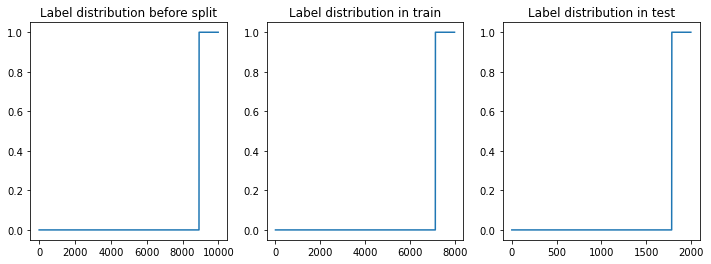

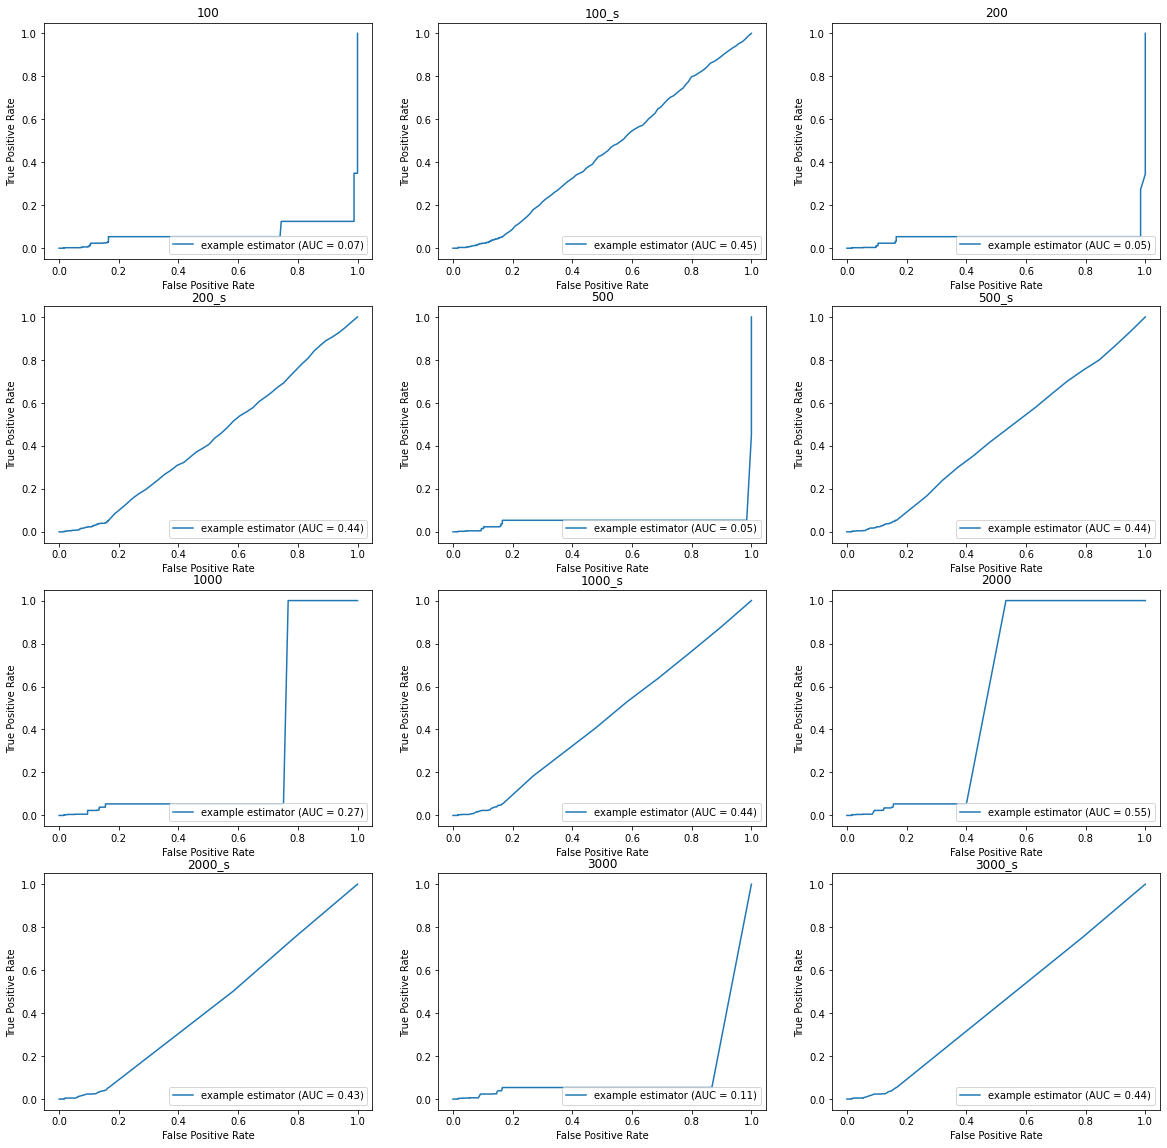

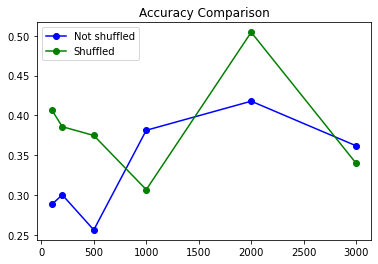

WINDOW SIZE NOT SHUFFLED: 2000
WINDOW SIZE SHUFFLED: 2000
Threshold value is: 0.010767775603392038
Threshold value is: 0.010554207436399232


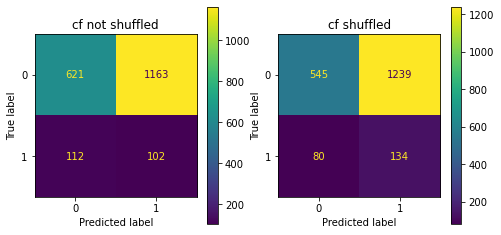

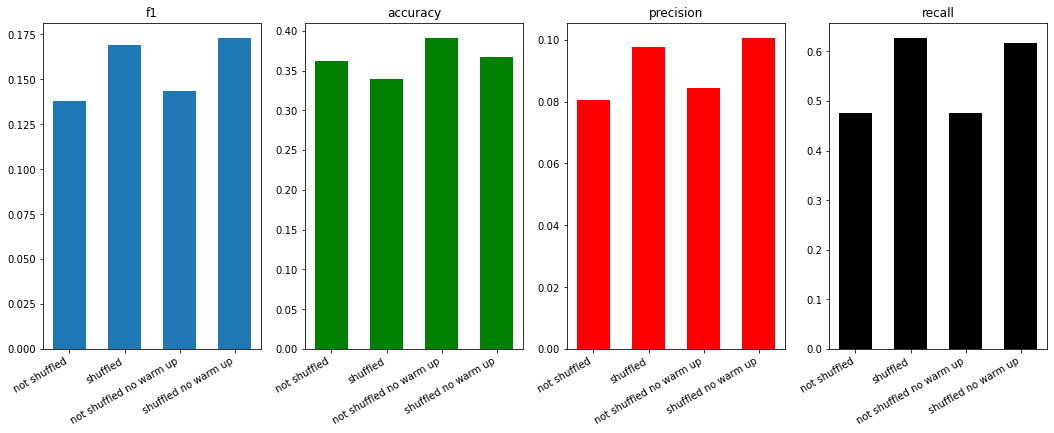

=========Results not shuffled=======
Accuracy:0.361862
Precision:0.080632
Recall:0.476636
F1:0.137931
=========Results shuffled=======
Accuracy:0.339840
Precision:0.097597
Recall:0.626168
F1:0.168872


In [176]:
acc_0, acc_s_0, f1_0, f1_s_0=pipeline_SML(x_00, y_00, "Model00", t_l=0)

#### Without transfer learning the model is extremely slow and has very poor results, so it is meaningless to show it for all the valves

## Transfer learning with 800 as output shape

In [177]:
x_00=np.load('valves/id_00/X.npy')
y_00=np.load('valves/id_00/y.npy')

x_02=np.load('valves/id_02/X.npy')
y_02=np.load('valves/id_02/y.npy')

x_04=np.load('valves/id_04/X.npy')
y_04=np.load('valves/id_04/y.npy')

x_06=np.load('valves/id_06/X.npy')
y_06=np.load('valves/id_06/y.npy')

======Transfer learning=====


100%|██████████| 9990/9990 [08:08<00:00, 20.44it/s]


New shape:
(9990, 800)
======Data preprocessing=====
Training set label proportions: 0.8927677677677678 0.10723223223223223
Testing set label proportions: 0.8928928928928929 0.10710710710710711


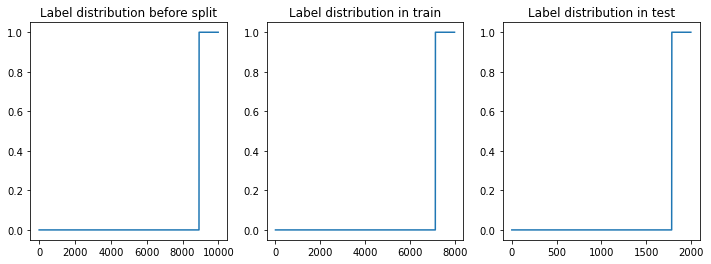

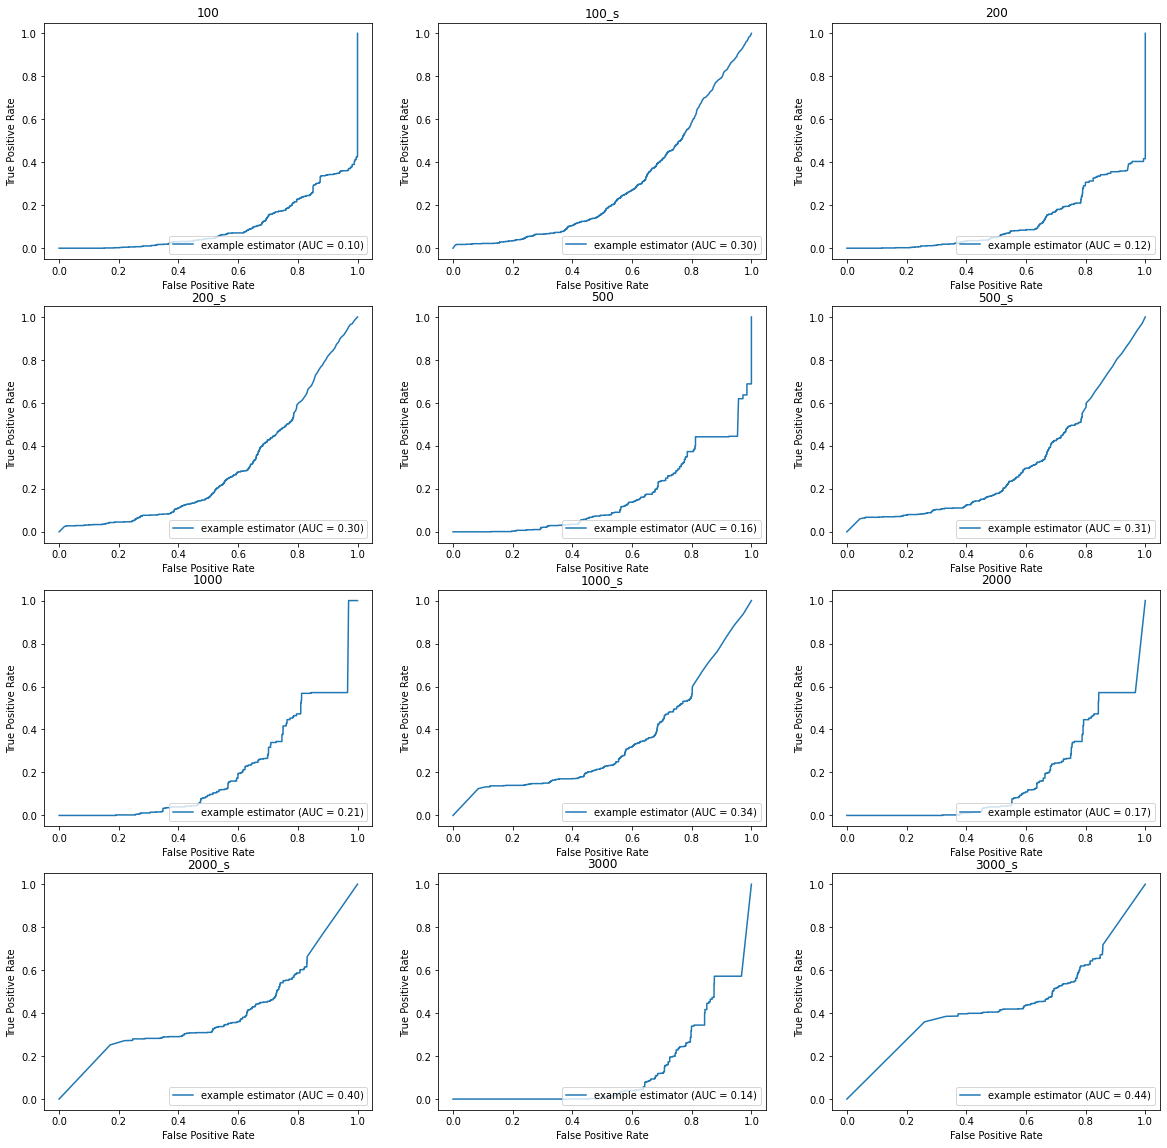

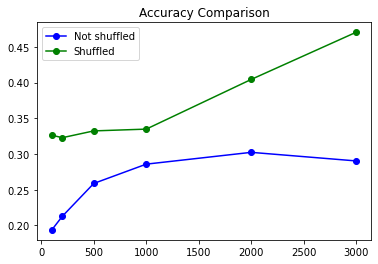

WINDOW SIZE NOT SHUFFLED: 2000
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.26555485975212
Threshold value is: 0.35132950641443794


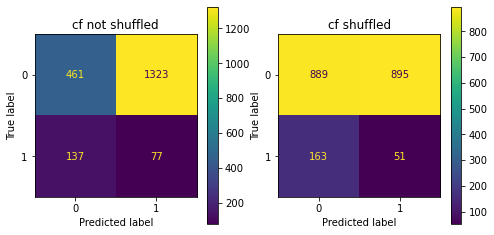

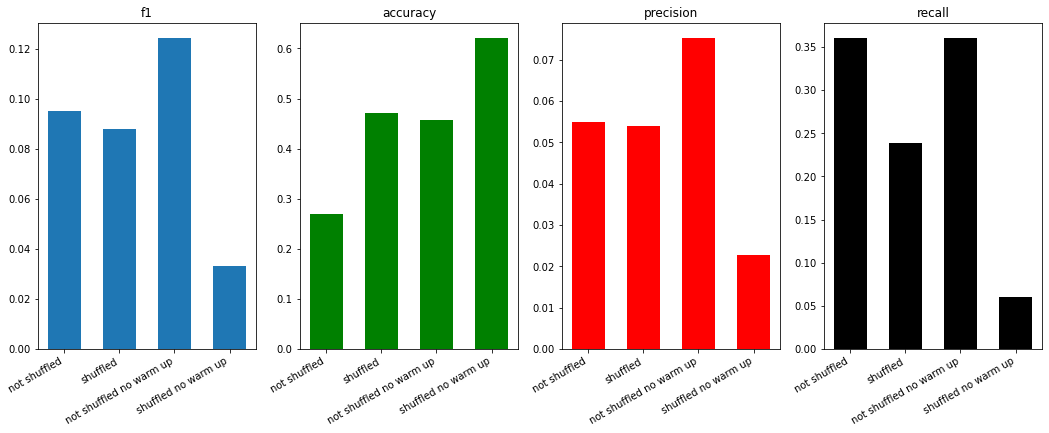

=========Results not shuffled=======
Accuracy:0.269269
Precision:0.055000
Recall:0.359813
F1:0.095415
=========Results shuffled=======
Accuracy:0.470470
Precision:0.053911
Recall:0.238318
F1:0.087931


In [181]:
acc_0, acc_s_0, f1_0, f1_s_0=pipeline_SML(x_00, y_00, "Model00", t_l=1)

======Transfer learning=====


100%|██████████| 7452/7452 [05:53<00:00, 21.06it/s]


New shape:
(7452, 800)
======Data preprocessing=====
Training set label proportions: 0.8550578761952693 0.14494212380473076
Testing set label proportions: 0.8551307847082495 0.1448692152917505


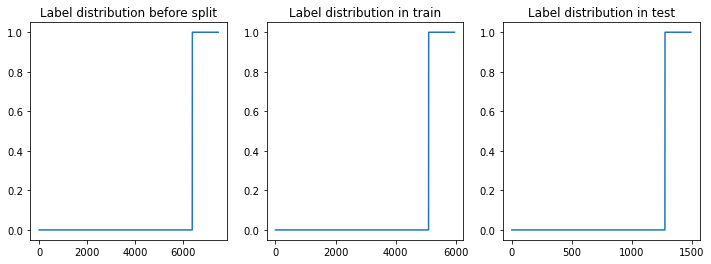

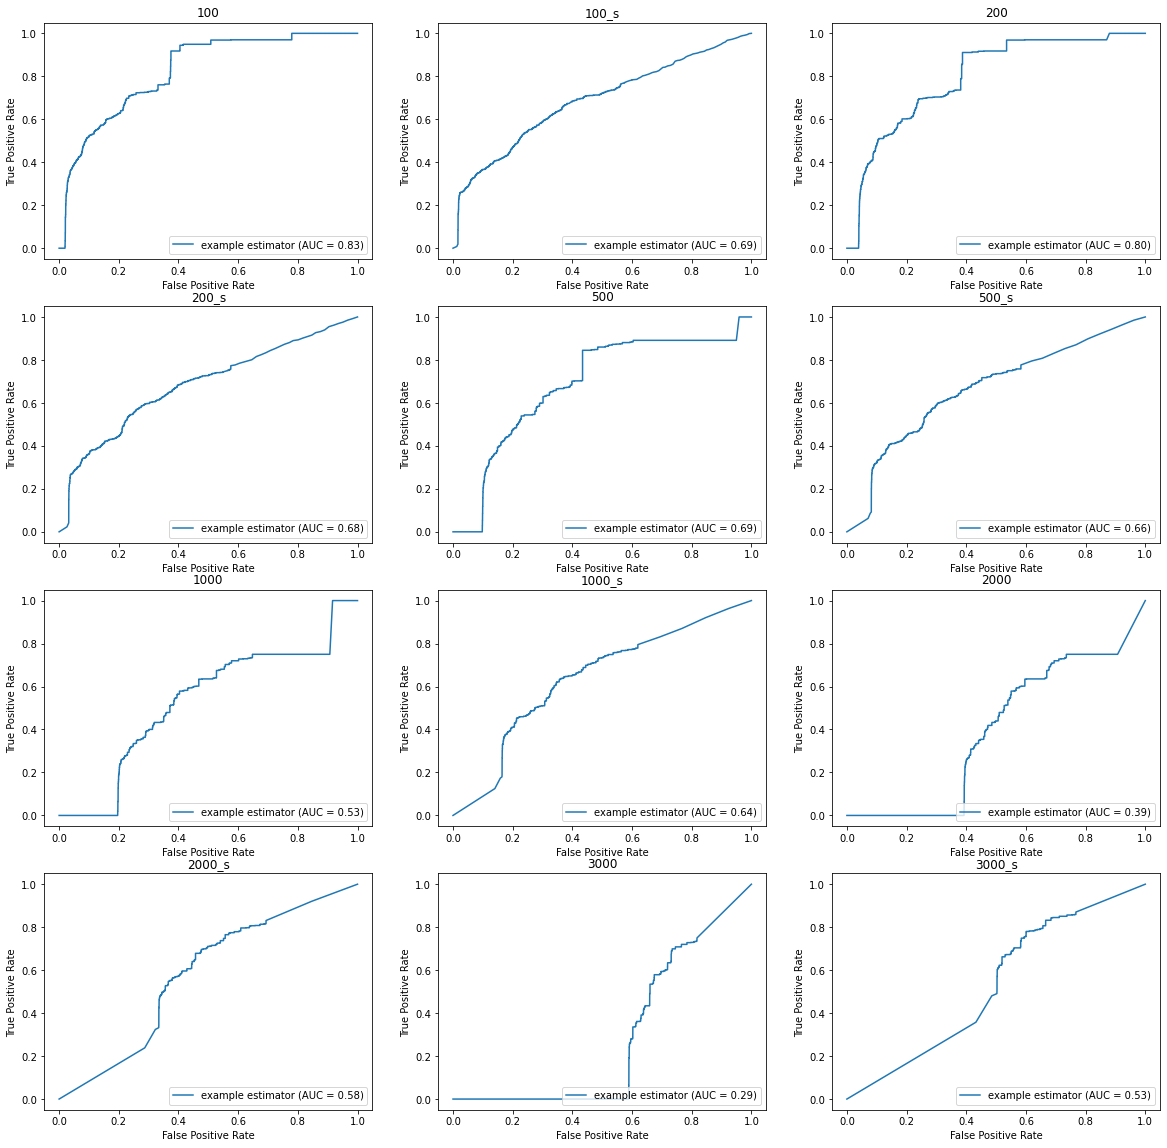

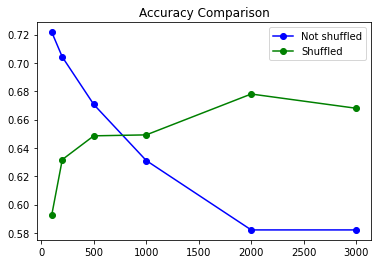

WINDOW SIZE NOT SHUFFLED: 100
WINDOW SIZE SHUFFLED: 2000
Threshold value is: 0.18408610567514672
Threshold value is: 0.23746966731898234


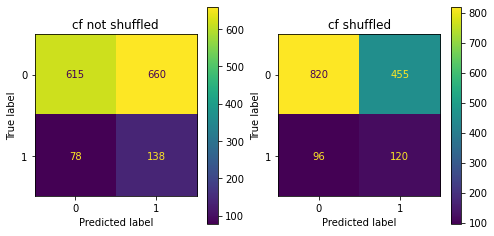

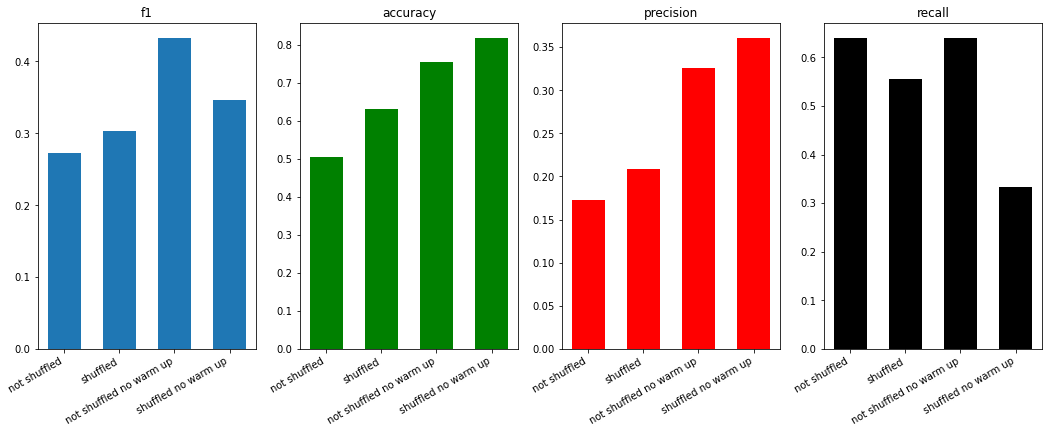

=========Results not shuffled=======
Accuracy:0.505030
Precision:0.172932
Recall:0.638889
F1:0.272189
=========Results shuffled=======
Accuracy:0.630449
Precision:0.208696
Recall:0.555556
F1:0.303413


In [182]:
acc_2, acc_s_2, f1_2, f1_s_2 =pipeline_SML(x_02, y_02, "Model02", t_l=1)

======Transfer learning=====


100%|██████████| 10080/10080 [07:41<00:00, 21.85it/s]


New shape:
(10080, 800)
======Data preprocessing=====
Training set label proportions: 0.8928571428571429 0.10714285714285714
Testing set label proportions: 0.8928571428571429 0.10714285714285714


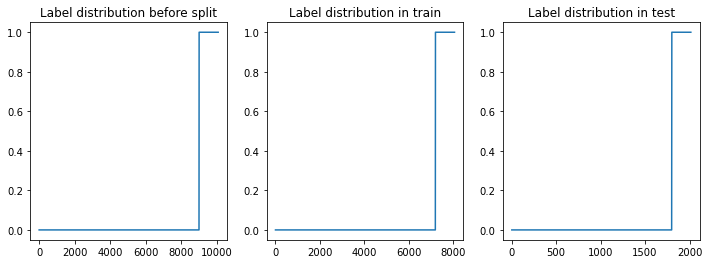

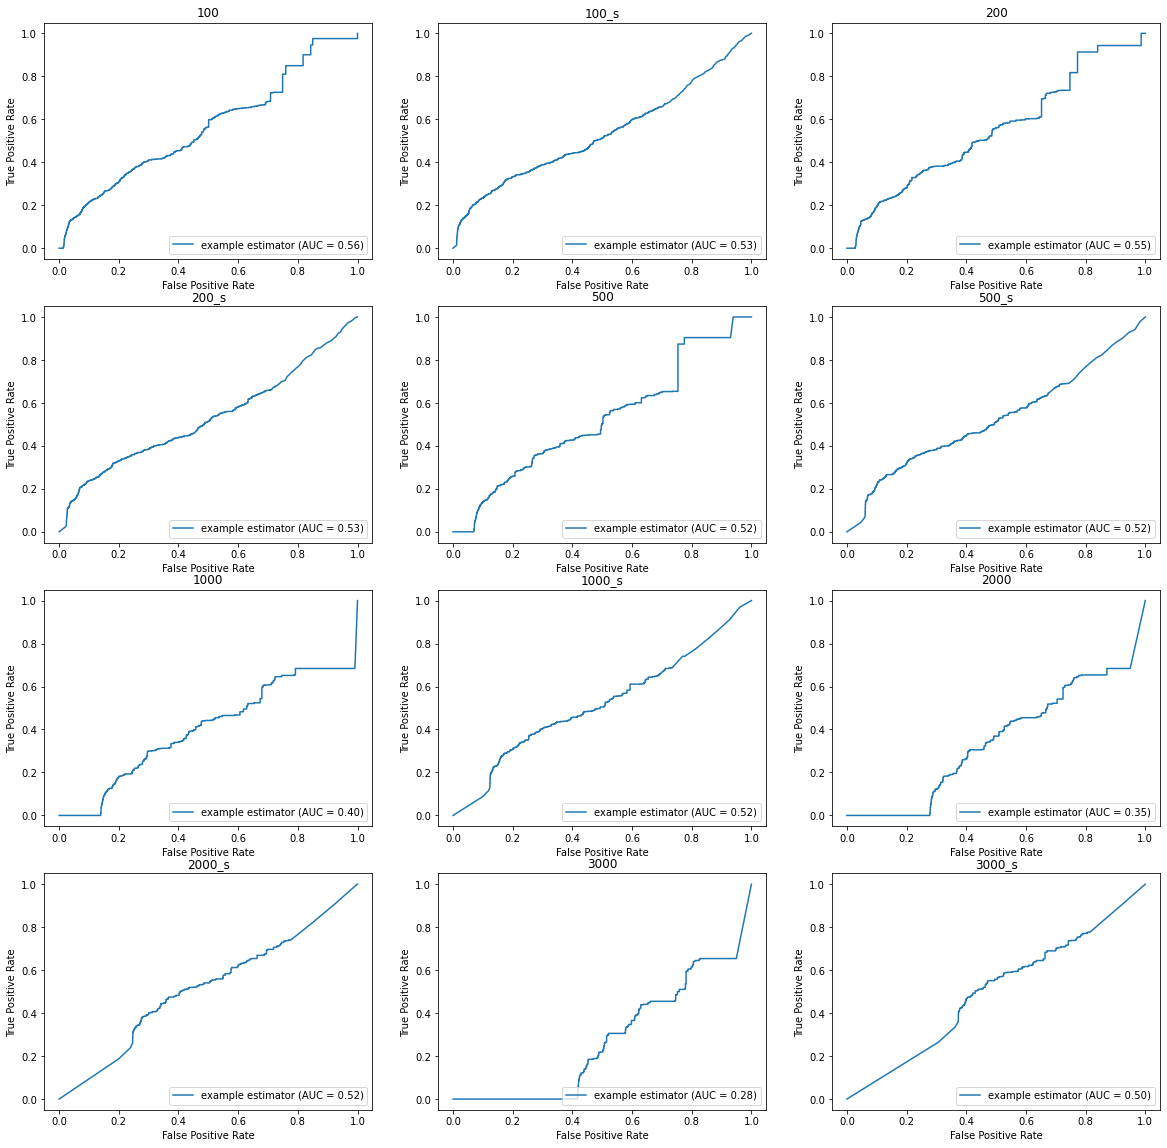

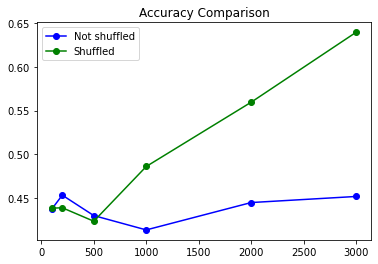

WINDOW SIZE NOT SHUFFLED: 200
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.16231441617742992
Threshold value is: 0.23866788432267882


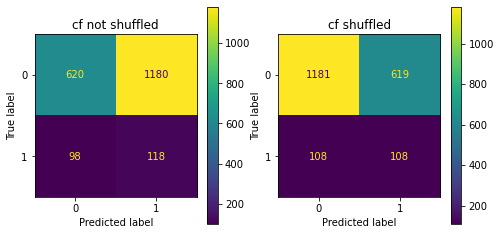

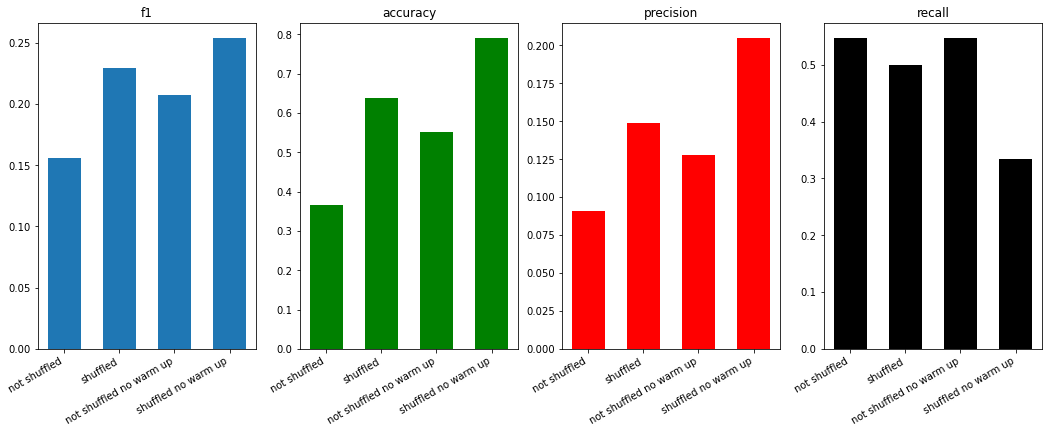

=========Results not shuffled=======
Accuracy:0.366071
Precision:0.090909
Recall:0.546296
F1:0.155878
=========Results shuffled=======
Accuracy:0.639385
Precision:0.148556
Recall:0.500000
F1:0.229056


In [183]:
acc_4, acc_s_4, f1_4, f1_s_4=pipeline_SML(x_04, y_04, "Model04", t_l=1)

======Transfer learning=====


100%|██████████| 10008/10008 [06:56<00:00, 24.01it/s]


New shape:
(10008, 800)
======Data preprocessing=====
Training set label proportions: 0.8920809392955283 0.10791906070447164
Testing set label proportions: 0.8921078921078921 0.10789210789210789


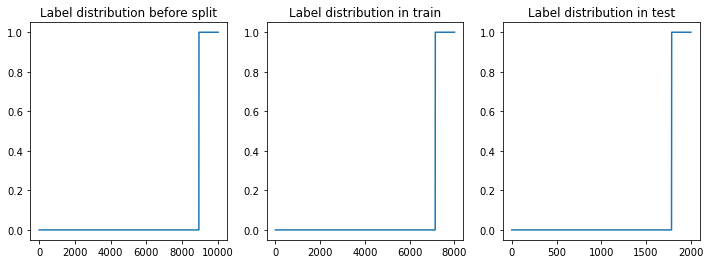

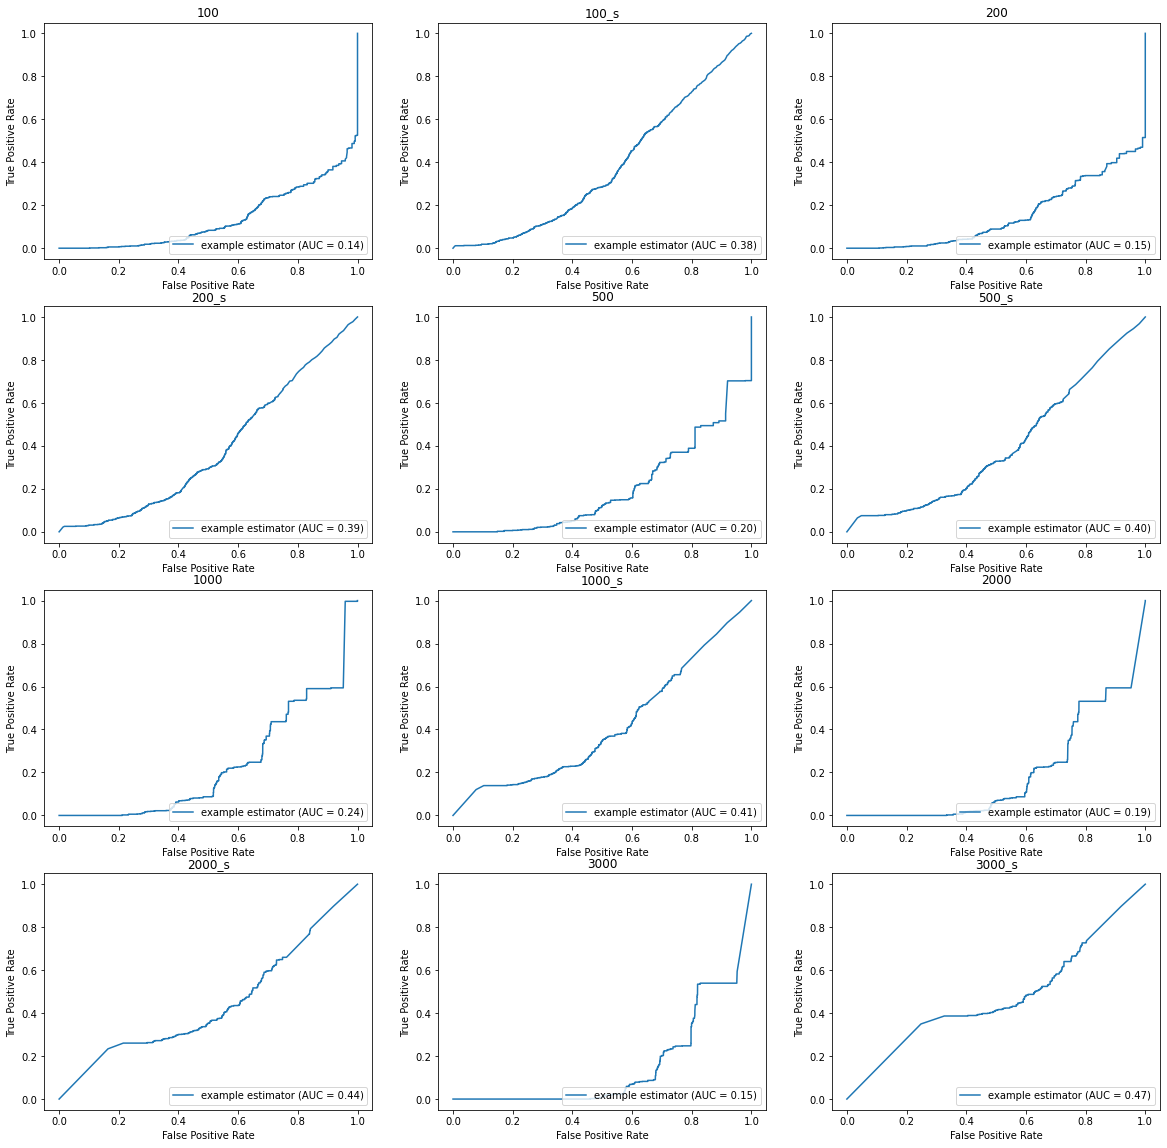

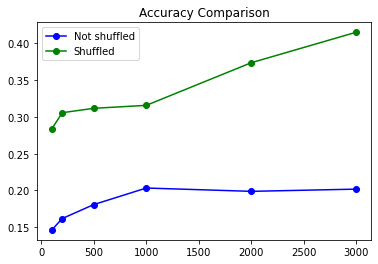

WINDOW SIZE NOT SHUFFLED: 1000
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.17620456621004565
Threshold value is: 0.2480061752554903


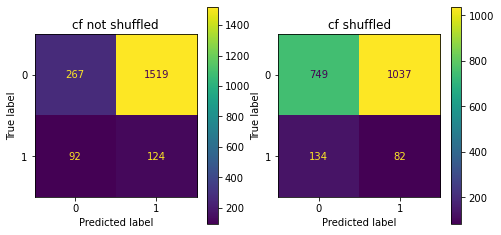

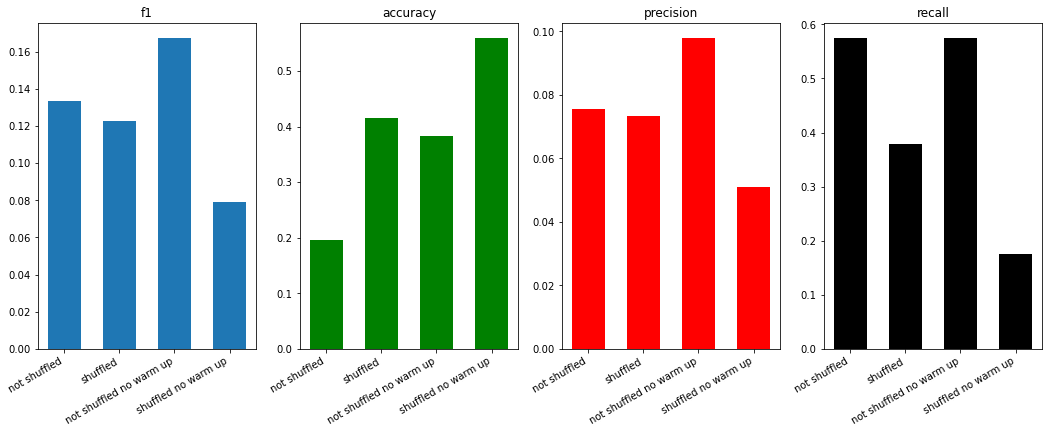

=========Results not shuffled=======
Accuracy:0.195305
Precision:0.075472
Recall:0.574074
F1:0.133405
=========Results shuffled=======
Accuracy:0.415085
Precision:0.073280
Recall:0.379630
F1:0.122846


In [184]:
acc_6, acc_s_6, f1_6, f1_s_6=pipeline_SML(x_06, y_06, "Model06", t_l=1)

In [260]:
# unified model
ids=['02','04','06']
x=np.load('valves/id_00/X.npy')
y=np.load('valves/id_00/y.npy')
print(np.unique(y[:,0], return_counts=True))
for i in ids:
    x_temp=np.load('valves/id_'+i+'/X.npy')
    y_temp=np.load('valves/id_'+i+'/y.npy')
    print(np.unique(y_temp[:,0], return_counts=True))
    x=np.concatenate((x,x_temp))
    y=np.concatenate((y,y_temp))
print(x.shape,y.shape)

(array([1, 2]), array([1071, 8919], dtype=int64))
(array([1, 2]), array([1080, 6372], dtype=int64))
(array([1, 2]), array([1080, 9000], dtype=int64))
(array([1, 2]), array([1080, 8928], dtype=int64))
(37530, 12935) (37530, 4)


======Transfer learning=====


100%|██████████| 37530/37530 [45:05<00:00, 13.87it/s]    


New shape:
(37530, 800)
======Data preprocessing=====
Training set label proportions: 0.8851252331468159 0.11487476685318412
Testing set label proportions: 0.8851585398347989 0.11484146016520118


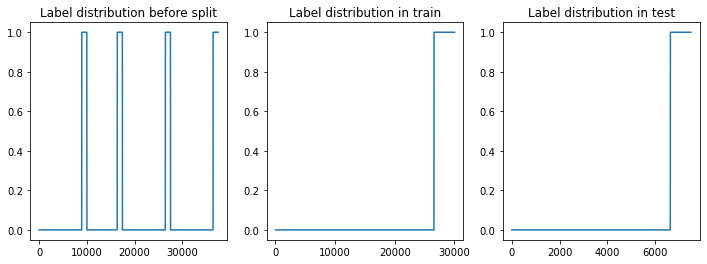

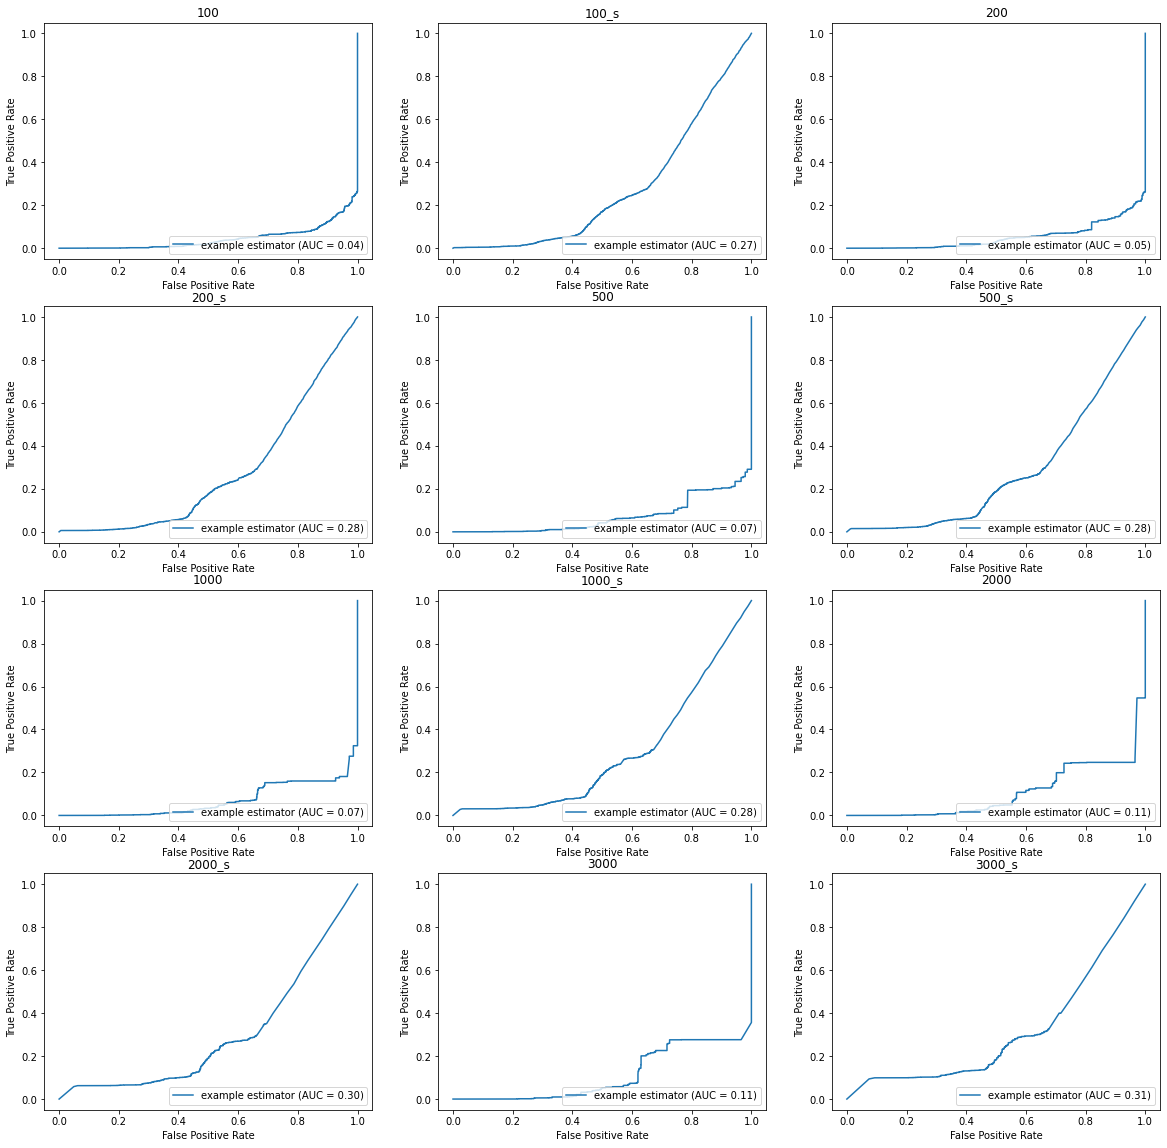

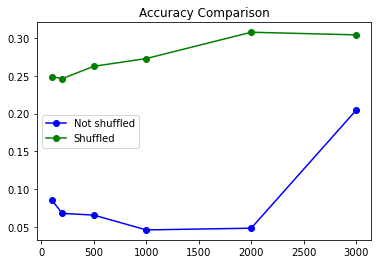

WINDOW SIZE NOT SHUFFLED: 3000
WINDOW SIZE SHUFFLED: 2000
Threshold value is: 0.10801530767558165
Threshold value is: 0.1182520547945205


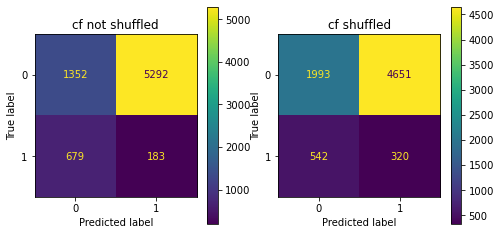

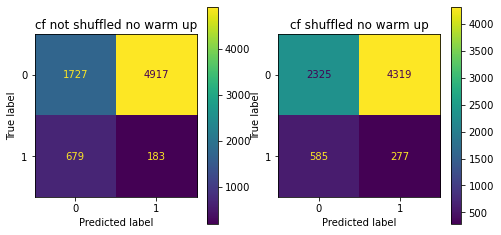

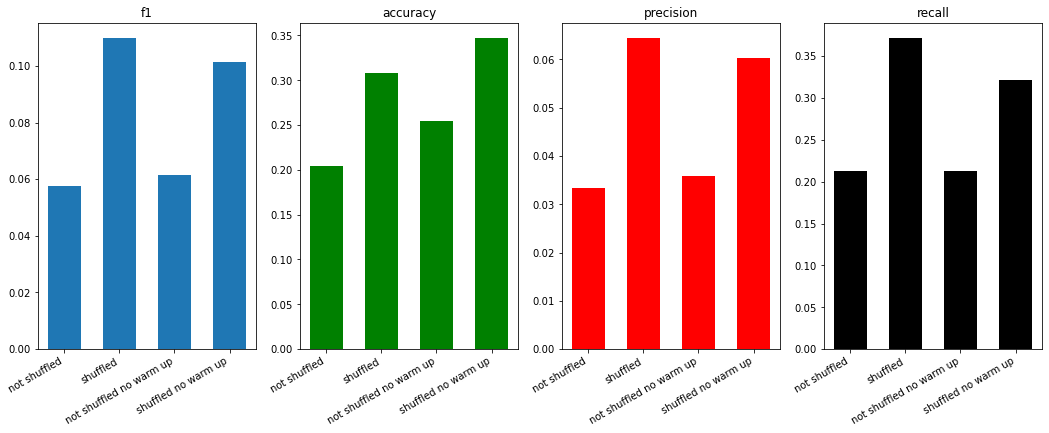

=========Results not shuffled=======
Accuracy:0.204503
Precision:0.033425
Recall:0.212297
F1:0.057756
=========Results shuffled=======
Accuracy:0.308153
Precision:0.064373
Recall:0.371230
F1:0.109721


In [261]:
acc, acc_s, f1, f1_s=pipeline_SML(x, y, "ModelUnified", t_l=1)

### Comparison between valves

In [262]:
labels=['unified','00', '02', '04', '06']
f1_list=[f1,f1_0, f1_2, f1_4, f1_6]
acc_list=[acc,acc_0, acc_2, acc_4, acc_6]
f1_s_list=[f1_s,f1_s_0, f1_s_2, f1_s_4, f1_s_6]
acc_s_list=[acc_s,acc_s_0, acc_s_2, acc_s_4, acc_s_6]

Text(0.5, 1.0, 'accuracy shuffled')

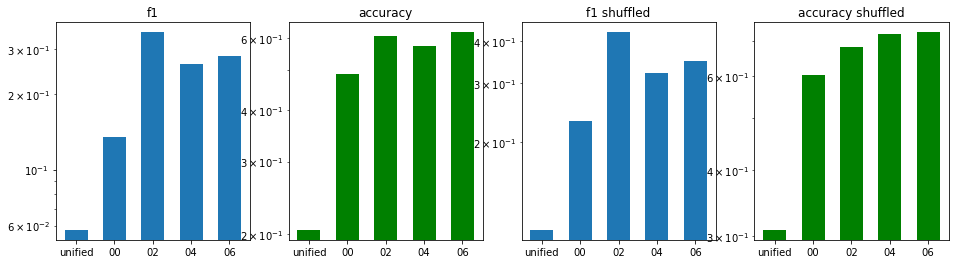

In [263]:
fig, ax= plt.subplots(1,4, figsize=(16,4))
ax[0].bar(labels, f1_list, width=0.6, log=True)
ax[0].set_title("f1")
ax[1].bar(labels, acc_list, width=0.6, log=True,color='green')
ax[1].set_title("accuracy")
ax[2].bar(labels, f1_s_list, width=0.6, log=True)
ax[2].set_title("f1 shuffled")
ax[3].bar(labels, acc_s_list, width=0.6, log=True,color='green')
ax[3].set_title("accuracy shuffled")

#### With 800 as input shape we see how the performances are still very poor

## Transfer learning with 20 as output shape

In [195]:
x_00=np.load('valves/id_00/X.npy')
y_00=np.load('valves/id_00/y.npy')

x_02=np.load('valves/id_02/X.npy')
y_02=np.load('valves/id_02/y.npy')

x_04=np.load('valves/id_04/X.npy')
y_04=np.load('valves/id_04/y.npy')

x_06=np.load('valves/id_06/X.npy')
y_06=np.load('valves/id_06/y.npy')

======Transfer learning=====


100%|██████████| 9990/9990 [08:45<00:00, 19.00it/s]


New shape:
(9990, 20)
======Data preprocessing=====
Training set label proportions: 0.8927677677677678 0.10723223223223223
Testing set label proportions: 0.8928928928928929 0.10710710710710711


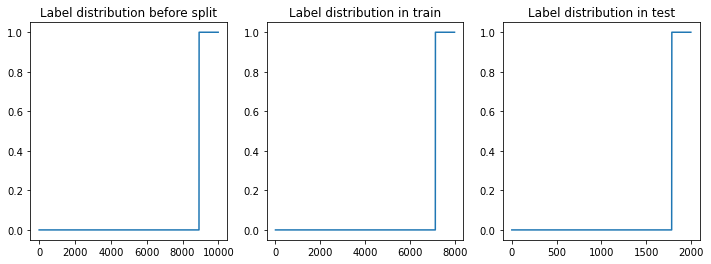

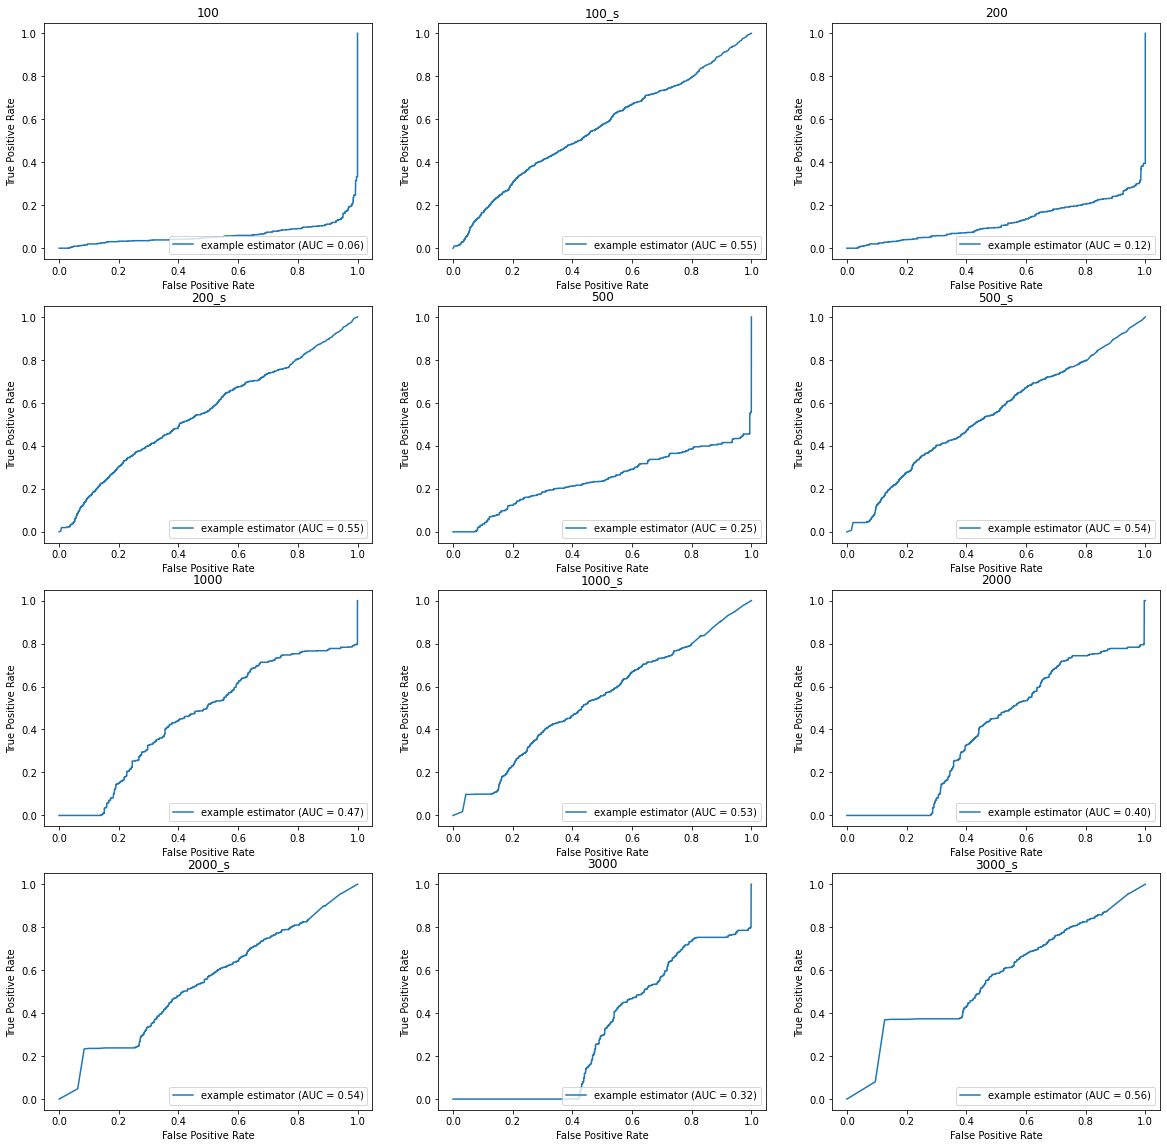

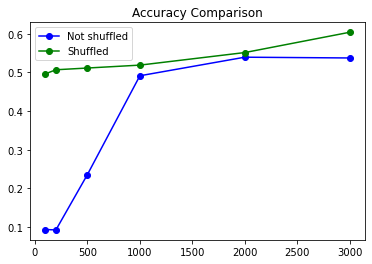

WINDOW SIZE NOT SHUFFLED: 2000
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.7905759947814742
Threshold value is: 0.8325348119156338


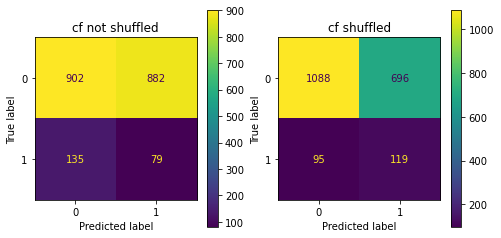

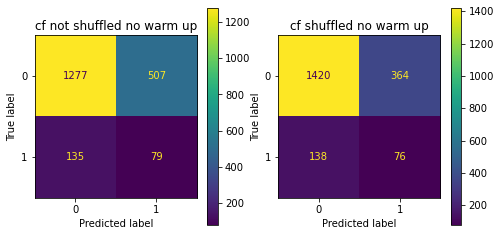

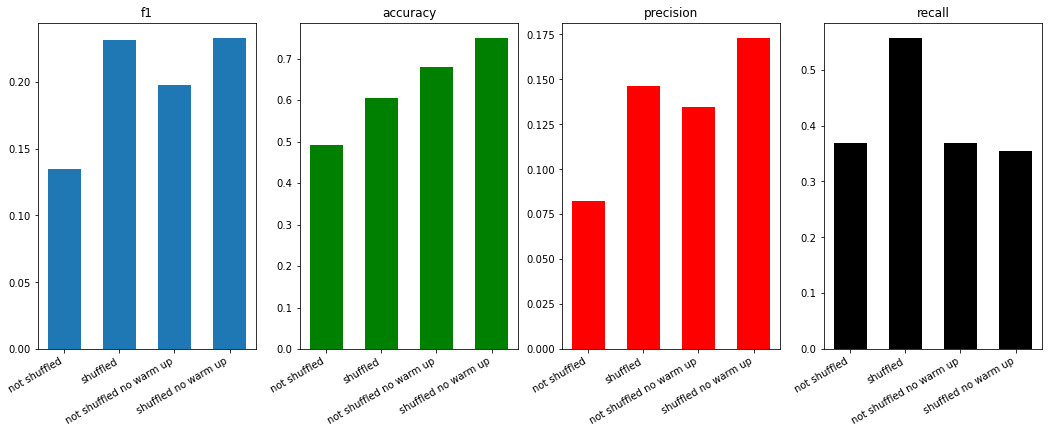

=========Results not shuffled=======
Accuracy:0.490991
Precision:0.082206
Recall:0.369159
F1:0.134468
=========Results shuffled=======
Accuracy:0.604104
Precision:0.146012
Recall:0.556075
F1:0.231293


In [196]:
acc_0, acc_s_0, f1_0, f1_s_0=pipeline_SML(x_00, y_00, "Model00", t_l=2)

======Transfer learning=====


100%|██████████| 7452/7452 [05:13<00:00, 23.73it/s]


New shape:
(7452, 20)
======Data preprocessing=====
Training set label proportions: 0.8550578761952693 0.14494212380473076
Testing set label proportions: 0.8551307847082495 0.1448692152917505


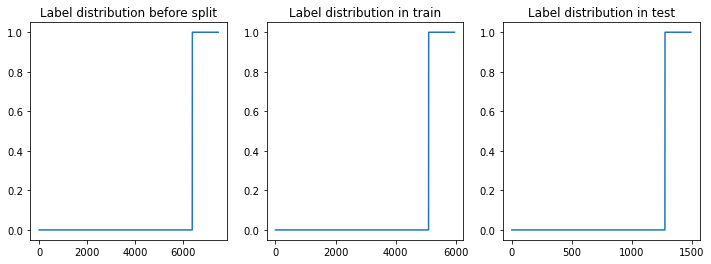

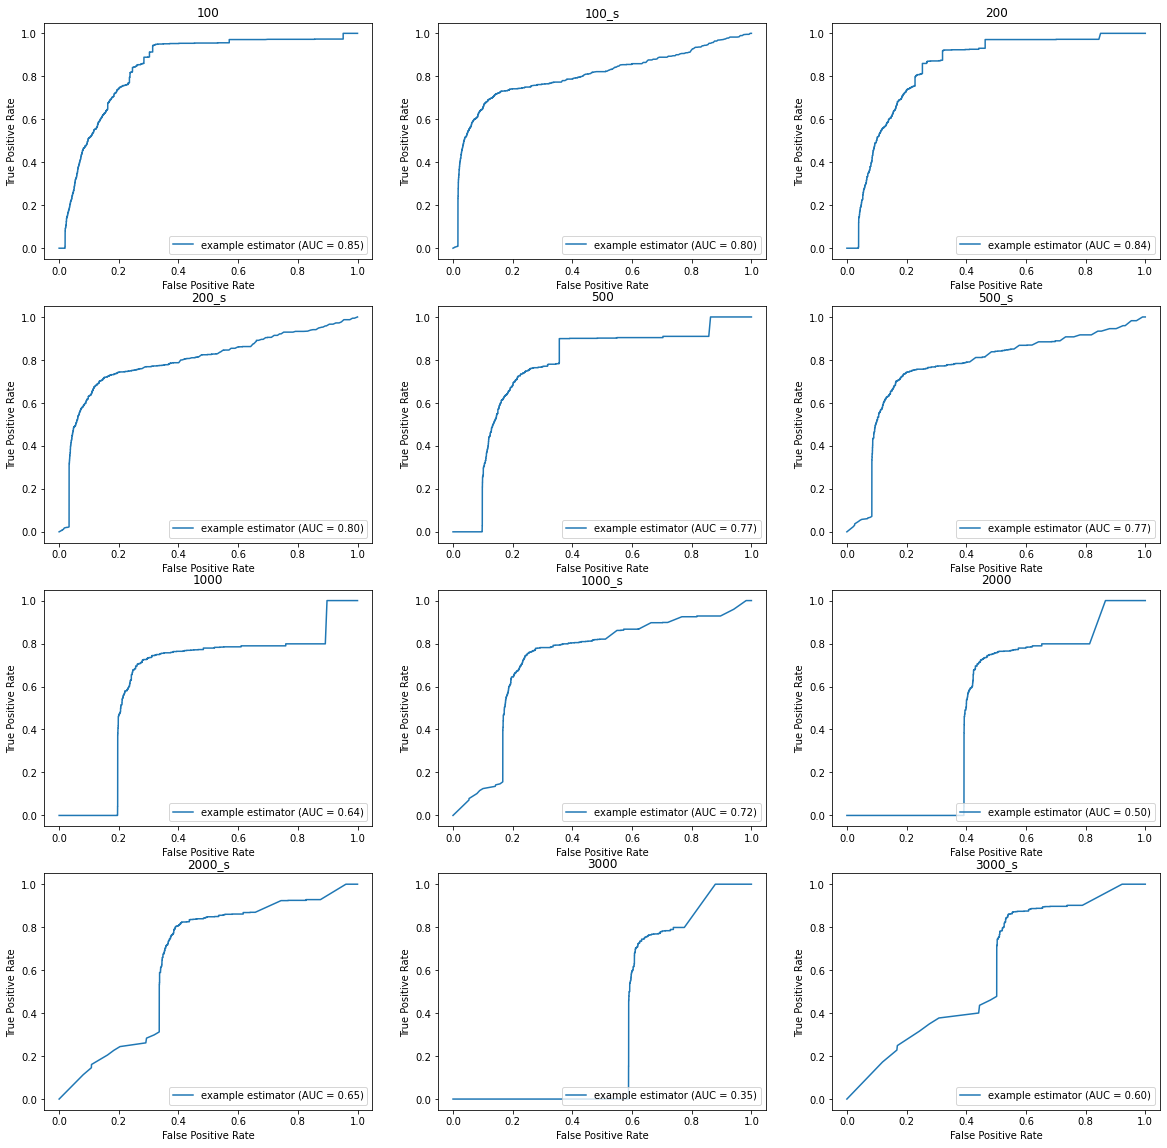

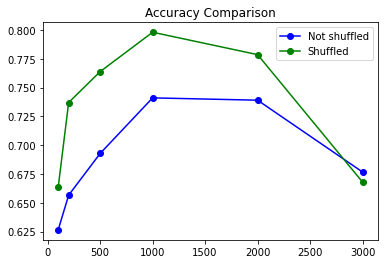

WINDOW SIZE NOT SHUFFLED: 1000
WINDOW SIZE SHUFFLED: 1000
Threshold value is: 0.6445448140900196
Threshold value is: 0.6685774298760601


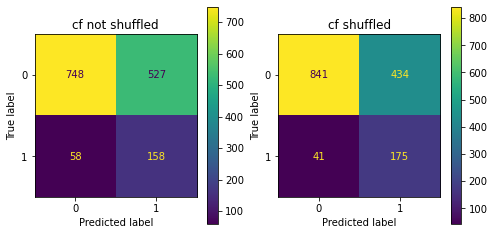

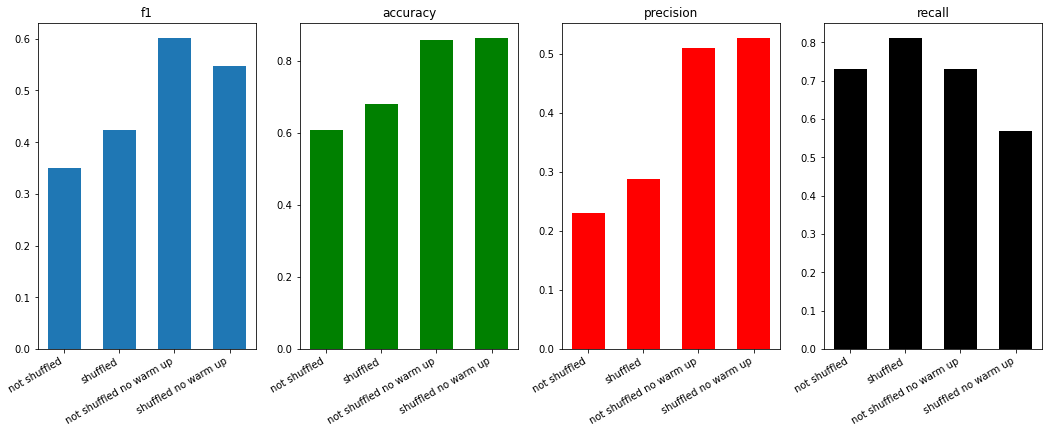

=========Results not shuffled=======
Accuracy:0.607646
Precision:0.230657
Recall:0.731481
F1:0.350721
=========Results shuffled=======
Accuracy:0.681422
Precision:0.287356
Recall:0.810185
F1:0.424242


In [189]:
acc_2, acc_s_2, f1_2, f1_s_2 =pipeline_SML(x_02, y_02, "Model02", t_l=2)

======Transfer learning=====


100%|██████████| 10080/10080 [07:03<00:00, 23.80it/s]


New shape:
(10080, 20)
======Data preprocessing=====
Training set label proportions: 0.8928571428571429 0.10714285714285714
Testing set label proportions: 0.8928571428571429 0.10714285714285714


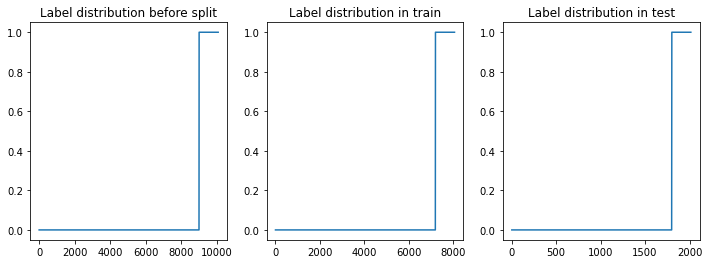

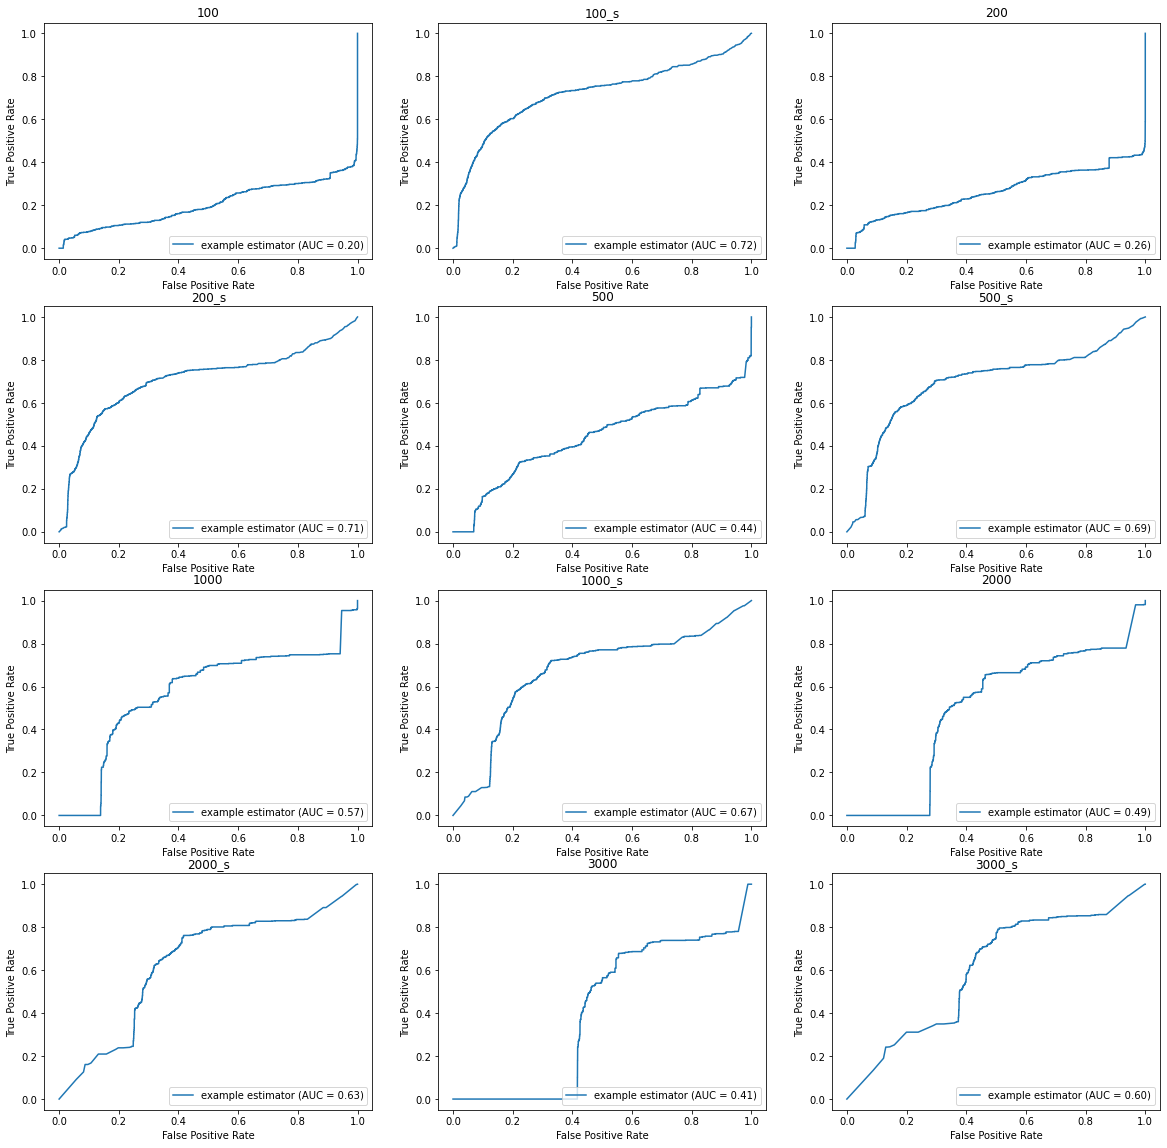

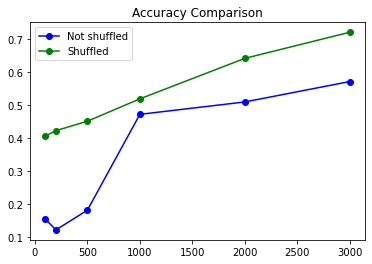

WINDOW SIZE NOT SHUFFLED: 3000
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.7445908240921939
Threshold value is: 0.8179535551206785


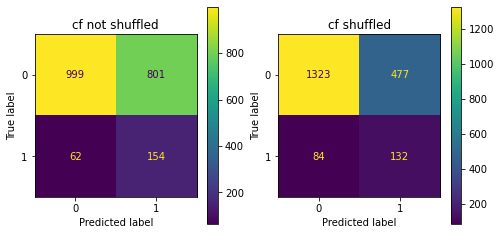

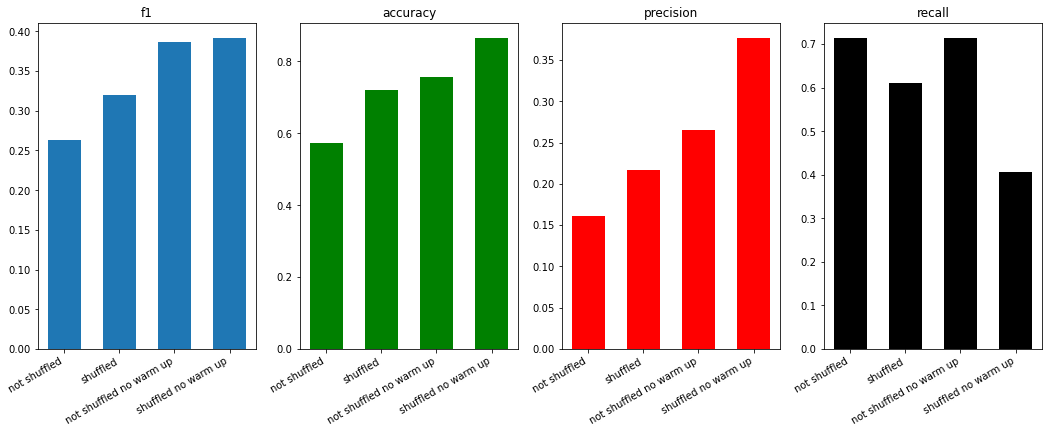

=========Results not shuffled=======
Accuracy:0.571925
Precision:0.161257
Recall:0.712963
F1:0.263023
=========Results shuffled=======
Accuracy:0.721726
Precision:0.216749
Recall:0.611111
F1:0.320000


In [190]:
acc_4, acc_s_4, f1_4, f1_s_4=pipeline_SML(x_04, y_04, "Model04", t_l=2)

======Transfer learning=====


100%|██████████| 10008/10008 [06:57<00:00, 23.95it/s]


New shape:
(10008, 20)
======Data preprocessing=====
Training set label proportions: 0.8920809392955283 0.10791906070447164
Testing set label proportions: 0.8921078921078921 0.10789210789210789


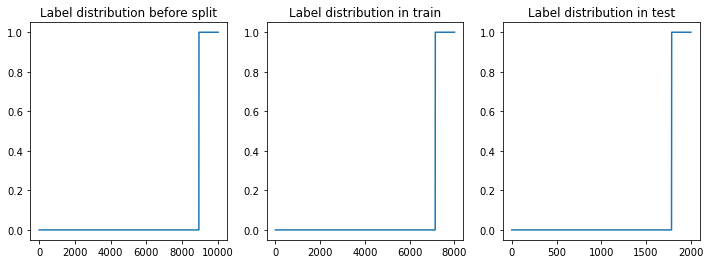

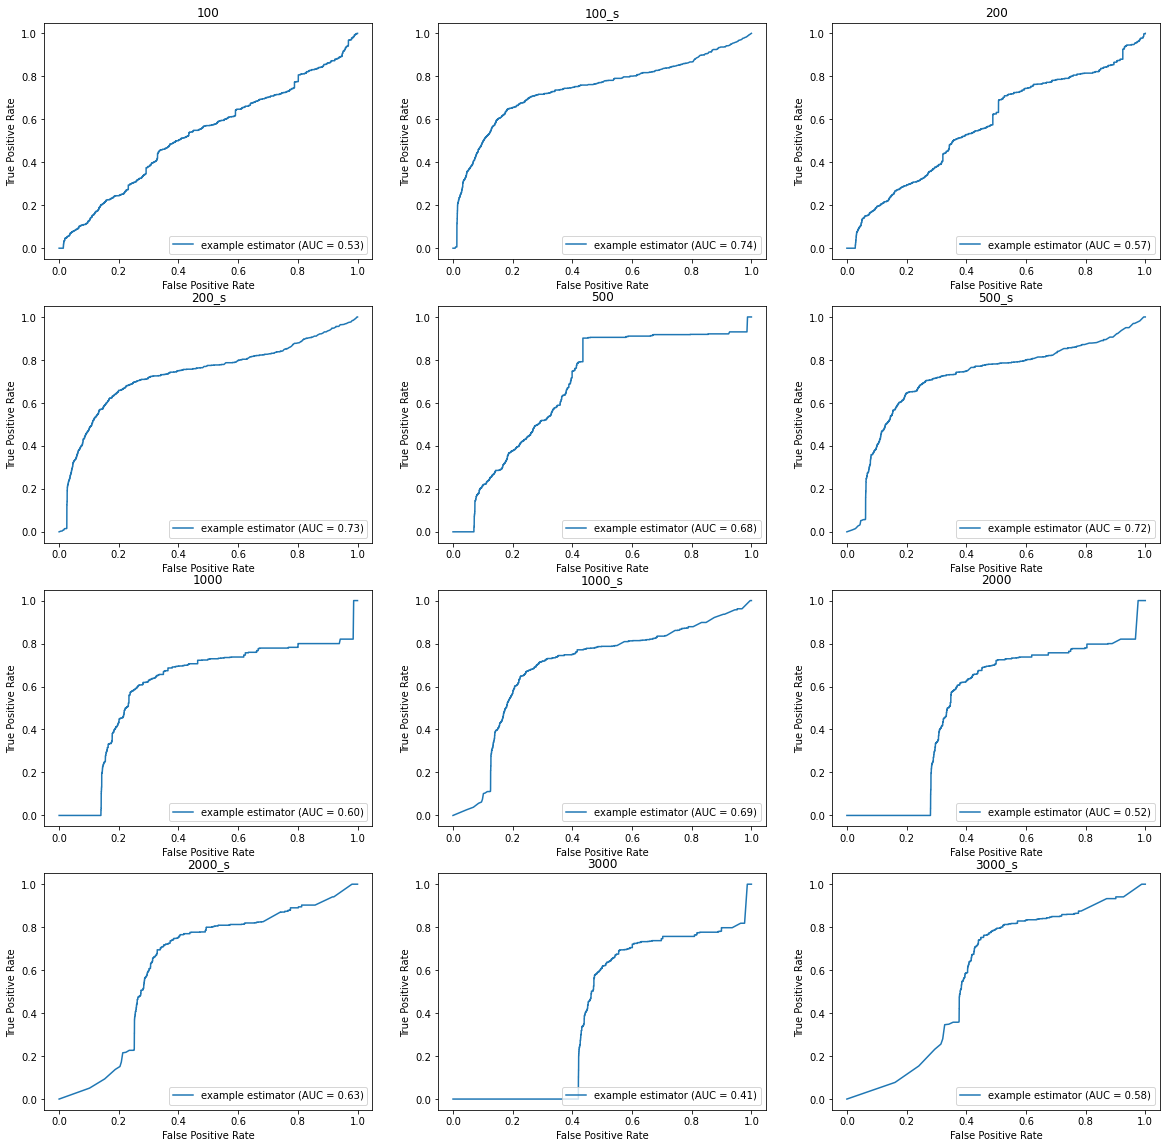

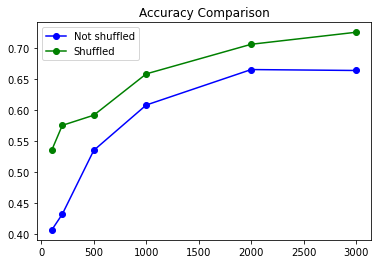

WINDOW SIZE NOT SHUFFLED: 2000
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.6449599478147423
Threshold value is: 0.7703059795607741


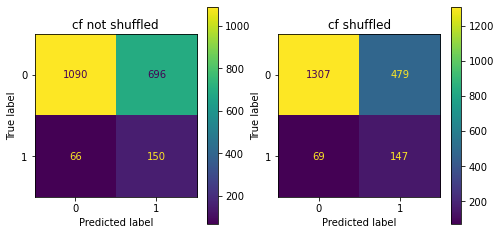

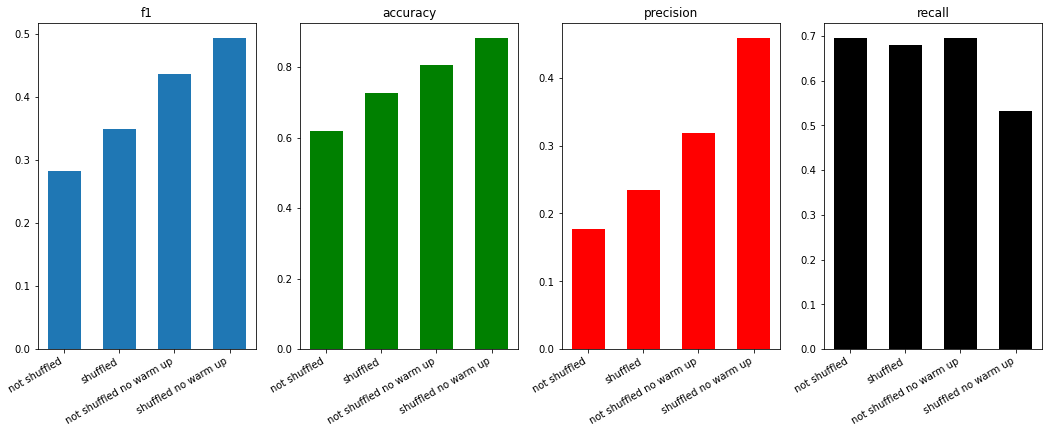

=========Results not shuffled=======
Accuracy:0.619381
Precision:0.177305
Recall:0.694444
F1:0.282486
=========Results shuffled=======
Accuracy:0.726274
Precision:0.234824
Recall:0.680556
F1:0.349169


In [191]:
acc_6, acc_s_6, f1_6, f1_s_6=pipeline_SML(x_06, y_06, "Model06", t_l=2)

In [255]:
# unified model
ids=['02','04','06']
x=np.load('valves/id_00/X.npy')
y=np.load('valves/id_00/y.npy')
print(np.unique(y[:,0], return_counts=True))
for i in ids:
    x_temp=np.load('valves/id_'+i+'/X.npy')
    y_temp=np.load('valves/id_'+i+'/y.npy')
    print(np.unique(y_temp[:,0], return_counts=True))
    x=np.concatenate((x,x_temp))
    y=np.concatenate((y,y_temp))
print(x.shape,y.shape)

(array([1, 2]), array([1071, 8919], dtype=int64))
(array([1, 2]), array([1080, 6372], dtype=int64))
(array([1, 2]), array([1080, 9000], dtype=int64))
(array([1, 2]), array([1080, 8928], dtype=int64))
(37530, 12935) (37530, 4)


======Transfer learning=====


100%|██████████| 37530/37530 [18:24:42<00:00,  1.77s/it]        


New shape:
(37530, 20)
======Data preprocessing=====
Training set label proportions: 0.8851252331468159 0.11487476685318412
Testing set label proportions: 0.8851585398347989 0.11484146016520118


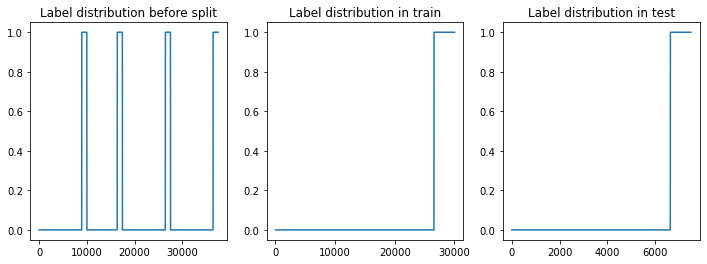

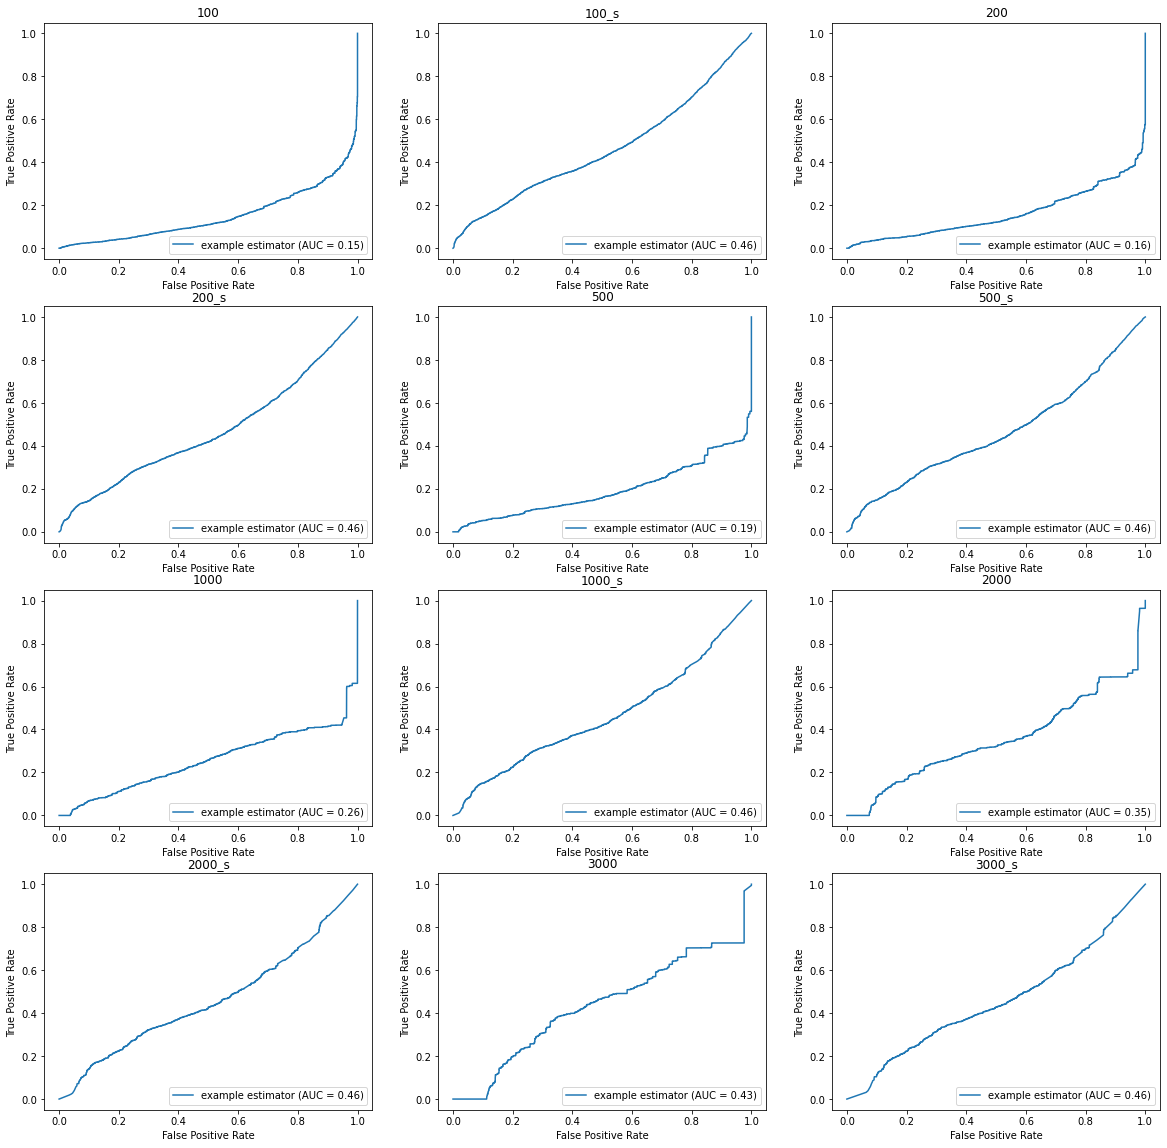

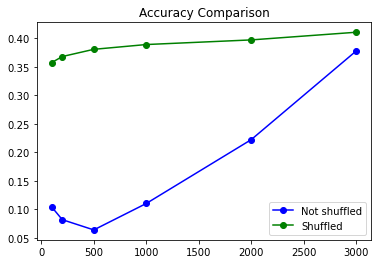

WINDOW SIZE NOT SHUFFLED: 3000
WINDOW SIZE SHUFFLED: 3000
Threshold value is: 0.567944596651446
Threshold value is: 0.5573785605566428


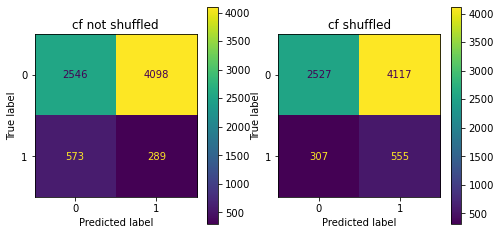

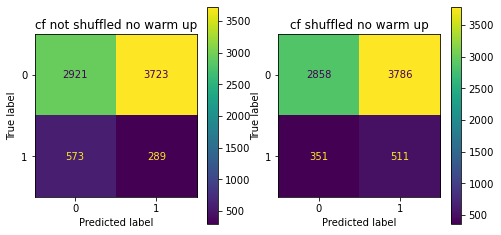

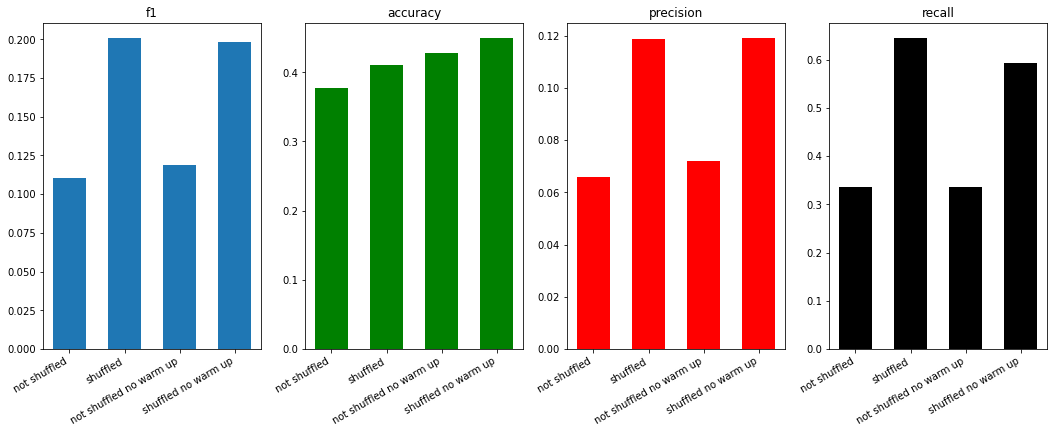

=========Results not shuffled=======
Accuracy:0.377698
Precision:0.065876
Recall:0.335267
F1:0.110116
=========Results shuffled=======
Accuracy:0.410605
Precision:0.118793
Recall:0.643852
F1:0.200578


In [256]:
acc, acc_s, f1, f1_s=pipeline_SML(x, y, "ModelUnified", t_l=2)

### Comparison between valves

In [257]:
labels=['unified','00', '02', '04', '06']
f1_list=[f1,f1_0, f1_2, f1_4, f1_6]
acc_list=[acc,acc_0, acc_2, acc_4, acc_6]
f1_s_list=[f1_s,f1_s_0, f1_s_2, f1_s_4, f1_s_6]
acc_s_list=[acc_s,acc_s_0, acc_s_2, acc_s_4, acc_s_6]

Text(0.5, 1.0, 'accuracy shuffled')

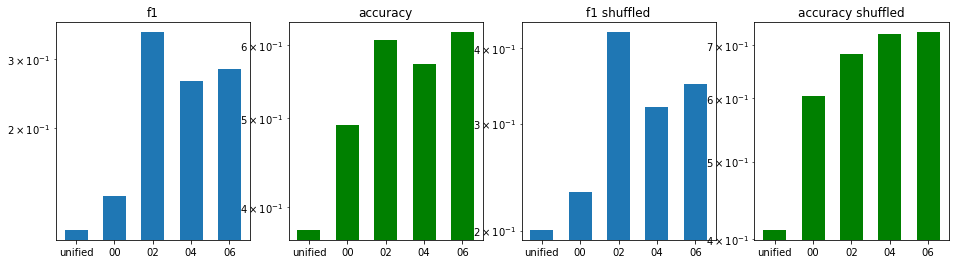

In [258]:
fig, ax= plt.subplots(1,4, figsize=(16,4))
ax[0].bar(labels, f1_list, width=0.6, log=True)
ax[0].set_title("f1")
ax[1].bar(labels, acc_list, width=0.6, log=True,color='green')
ax[1].set_title("accuracy")
ax[2].bar(labels, f1_s_list, width=0.6, log=True)
ax[2].set_title("f1 shuffled")
ax[3].bar(labels, acc_s_list, width=0.6, log=True,color='green')
ax[3].set_title("accuracy shuffled")

* As shown also with the Neural Network, the unified model performs worse than the single valves